# Competition for glucose, with internal goods X and Y, and social objective (model), linear/exponential growth rate

In [1]:
import cobra
import pandas as pd
import numpy as np
import pickle
from cobra.flux_analysis import pfba

In [2]:
# import map visualization tools
from utils import show_map
import escher
map_loc = 'Two cell system model_map.json' # the escher map used below
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

M = cobra.io.load_json_model('Two cell system model.json')
model = M.copy()

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


/Users/yanhualiu/Desktop/New_topic/model_building/model_building_exercise_by_yanhua/Cells' competition paper/Two cell types considering growth for paper/utils/findBiomarkers.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [3]:
b = show_map([],map_loc)
b

An empty solution was passed.


Builder(hide_secondary_metabolites=False, highlight_missing=True, reaction_data={}, reaction_scale=[{'type': '…

In [3]:
### Internal goods X and Y
model.reactions.EX_Com_goodX_e.lower_bound=0
model.reactions.EX_Com_goodY_e.lower_bound=0
model.reactions.EX_glucose_e.lower_bound=-1

In [4]:
fbasol = pfba(model)
b = show_map(fbasol,map_loc)
b

Builder(hide_secondary_metabolites=False, highlight_missing=True, reaction_data={'EX_glucose_e': -1.0, 'GlcT':…

In [6]:
### FVA result
rxnsOfInterest=['EX_glucose_e','GlcT','GTI1','GTI2','biomass1','biomass2','DI1X','DI2Y']
fvasol = cobra.flux_analysis.flux_variability_analysis(model,reaction_list=rxnsOfInterest,fraction_of_optimum=1)
fvasol

,minimum,maximum
EX_glucose_e,-1.00,-1.00
GlcT,1.00,1.00
GTI1,0.25,0.75
GTI2,0.25,0.75
biomass1,0.00,0.50
biomass2,0.00,0.50
DI1X,0.25,0.25
DI2Y,0.25,0.25


In [7]:
model.solver='glpk'
sol = model.optimize()
sol.objective_value

0.5

## Growing with time (Exponential growth)

In [27]:
model1=model.copy()

### µ1=0.2;µ2=0.3

<Figure size 640x480 with 0 Axes>

0.2 0.3 0.625 0.417 0.2 0.3 0.05


Text(0.5, 0, 't (month)')

(0.0, 3.0)

Text(0.5, 1.0, 'Exponential growth (µ1=0.2;µ2=0.3)')

Text(0, 0.5, '(required relative) flux (m C-Molar or fold excess)')

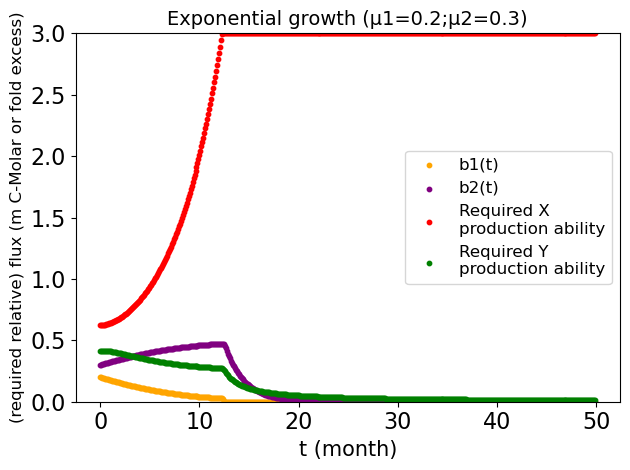

In [28]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.2]
Fluxes2_list=[0.3]
b1_list=[0.2]
b2_list=[0.3]
TotalB1=0
TotalB2=0
RequiredXproduction_list=[0.625]
RequiredYproduction_list=[0.417]
Bias_list=[0.05]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = [0.4]
B2_vals = [0.6]

def B1(t):
    if t <= 0:
        return 0.4
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]

def B2(t):
    if t <= 0:
        return 0.6
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]

for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
    
    b1=0.5*0.2*math.exp(0.2*t/10/0.5)/(0.2*math.exp(0.2*t/10/0.5)+0.3*math.exp(0.3*t/10/0.5))
    b2=0.5*0.3*math.exp(0.3*t/10/0.5)/(0.2*math.exp(0.2*t/10/0.5)+0.3*math.exp(0.3*t/10/0.5))
    b1_list.append(b1)
    b2_list.append(b2)
   
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    
    model1.reactions.biomass1.upper_bound=b1
    model1.reactions.biomass2.upper_bound=b2
    model1.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model1.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    
    sol = model1.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['DI1X']
    Fluxes4=sol.fluxes.loc['DI2Y']
    Fluxes5=sol.fluxes.loc['EX_glucose_e']
    Bias=(Fluxes2-Fluxes1)/2
    RequiredXproduction=Fluxes3/B1_vals[-1]
    RequiredYproduction=Fluxes3/B2_vals[-1]
    RequiredXproduction_list.append(RequiredXproduction)
    RequiredYproduction_list.append(RequiredYproduction)
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Bias_list.append(Bias)
    
    T=t/10
    T_list.append(T)

print(Fluxes1_list[0],Fluxes2_list[0],RequiredXproduction_list[0],RequiredYproduction_list[0],
     b1_list[0],b2_list[0],Bias_list[0])
    
# plt.scatter(T_list,B1_vals,color='orange',s=10)
# plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,b1_list,color='orange',s=10)
# plt.scatter(T_list,b2_list,color='purple',s=10)

# plt.scatter(T_list,Bias_list,color='red',s=10)

plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
plt.scatter(T_list,RequiredXproduction_list,color='red',s=10)
plt.scatter(T_list,RequiredYproduction_list,color='green',s=10)

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in exponential growth (µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("biomass synthesis value",fontsize=12)
# plt.legend(['b1(t)','b2(t)'],loc='center right',fontsize=12)


plt.xlabel("t (month)",fontsize=15)

# plt.ylim(0,0.25)
# plt.title('Actual growth rate bias (µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("Actual growth bias value",fontsize=12)
# plt.legend(["$\u03B2$(t)"], loc="center right", fontsize=12)

# plt.ylim(0,1)
# plt.title('Cell number in exponential growth (µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("Cell number (billions)",fontsize=12)
# plt.legend(['B1(t)','B2(t)'],loc='center right',fontsize=12)

plt.ylim(0,3)
plt.title('Exponential growth (µ1=0.2;µ2=0.3)',fontsize=14)
plt.ylabel("(required relative) flux (m C-Molar or fold excess)",fontsize=12)
plt.legend(['b1(t)','b2(t)','Required X\nproduction ability','Required Y\nproduction ability'],loc='center right',fontsize=12)


plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()

# plt.show()
plt.savefig('Two cell lines (Exponential growth)(Obj=b1+b2)',dpi=600)

### µ1=0.15; µ2=0.35

In [31]:
model1=model.copy()

<Figure size 640x480 with 0 Axes>

0.15 0.35 0.833 0.3571 0.15 0.35 0.1


Text(0.5, 0, 't (month)')

(0.0, 3.0)

Text(0.5, 1.0, 'Exponential growth (µ1=0.15;µ2=0.35)')

Text(0, 0.5, '(required relative) flux (m C-Molar or fold excess)')

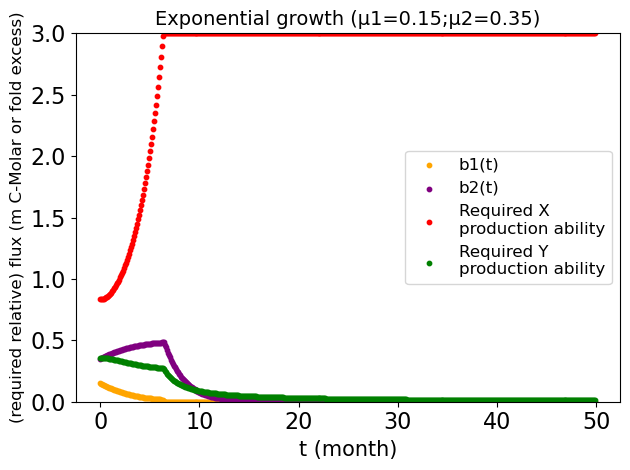

In [32]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.15]
Fluxes2_list=[0.35]
b1_list=[0.15]
b2_list=[0.35]
TotalB1=0
TotalB2=0
RequiredXproduction_list=[0.833]
RequiredYproduction_list=[0.3571]
Bias_list=[0.1]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = [0.3]
B2_vals = [0.7]

def B1(t):
    if t <= 0:
        return 0.3
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]

def B2(t):
    if t <= 0:
        return 0.7
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]

for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
    
    b1=0.5*0.15*math.exp(0.15*t/10/0.5)/(0.15*math.exp(0.15*t/10/0.5)+0.35*math.exp(0.35*t/10/0.5))
    b2=0.5*0.35*math.exp(0.35*t/10/0.5)/(0.15*math.exp(0.15*t/10/0.5)+0.35*math.exp(0.35*t/10/0.5))
    b1_list.append(b1)
    b2_list.append(b2)
  
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)

    model1.reactions.biomass1.upper_bound=b1
    model1.reactions.biomass2.upper_bound=b2
    model1.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model1.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    
    sol = model1.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['DI1X']
    Fluxes4=sol.fluxes.loc['DI2Y']
    Fluxes5=sol.fluxes.loc['EX_glucose_e']
    Bias=(Fluxes2-Fluxes1)/2
    RequiredXproduction=Fluxes3/B1_vals[-1]
    RequiredYproduction=Fluxes3/B2_vals[-1]
    RequiredXproduction_list.append(RequiredXproduction)
    RequiredYproduction_list.append(RequiredYproduction)
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Bias_list.append(Bias)
    T=t/10
    T_list.append(T)

print(Fluxes1_list[0],Fluxes2_list[0],RequiredXproduction_list[0],RequiredYproduction_list[0],
     b1_list[0],b2_list[0],Bias_list[0])    
# plt.scatter(T_list,B1_vals,color='orange',s=10)
# plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,b1_list,color='orange',s=10)
# plt.scatter(T_list,b2_list,color='purple',s=10)

# plt.scatter(T_list,Bias_list,color='red',s=10)

plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
plt.scatter(T_list,RequiredXproduction_list,color='red',s=10)
plt.scatter(T_list,RequiredYproduction_list,color='green',s=10)

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in exponential growth (µ1=0.15;µ2=0.35)',fontsize=12)
# plt.ylabel("biomass synthesis value",fontsize=12)
# plt.legend(['b1(t)','b2(t)'],loc='center right',fontsize=12)


plt.xlabel("t (month)",fontsize=15)

# plt.ylim(0,1)
# plt.title('Cell number in exponential growth (µ1=0.15;µ2=0.35)',fontsize=12)
# plt.ylabel("Cell number (billions)",fontsize=12)
# plt.legend(['B1(t)','B2(t)'],loc='center right',fontsize=12)

plt.ylim(0,3)
plt.title('Exponential growth (µ1=0.15;µ2=0.35)',fontsize=14)
plt.ylabel("(required relative) flux (m C-Molar or fold excess)",fontsize=12)
plt.legend(['b1(t)','b2(t)','Required X\nproduction ability','Required Y\nproduction ability'],loc='center right',fontsize=12)


# plt.ylim(0,0.25)
# plt.title('Actual growth rate bias (µ1=0.15;µ2=0.35)',fontsize=12)
# plt.ylabel("Actual growth bias value",fontsize=12)
# plt.legend(["$\u03B2$(t)"], loc="center right", fontsize=12)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()

# plt.show()
plt.savefig('Two cell lines (Exponential growth)(Obj=b1+b2)',dpi=600)

### µ1=0.05; µ2=0.45

In [23]:
model1=model.copy()

<Figure size 640x480 with 0 Axes>

0.05 0.45 2.5 0.28 0.05 0.45 0.2


Text(0.5, 0, 't (month)')

(0.0, 3.0)

Text(0.5, 1.0, 'Exponential growth (µ1=0.05;µ2=0.45)')

Text(0, 0.5, '(required relative) flux (m C-Molar or fold excess)')

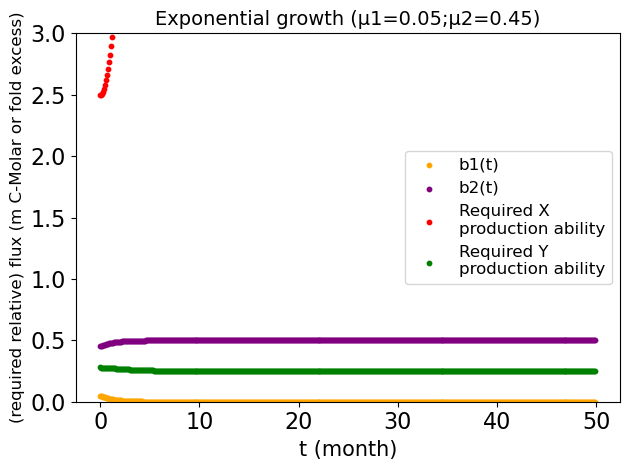

In [24]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.05]
Fluxes2_list=[0.45]
b1_list=[0.05]
b2_list=[0.45]
TotalB1=0
TotalB2=0
RequiredXproduction_list=[2.5]
RequiredYproduction_list=[0.28]
Bias_list=[0.2]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = [0.1]
B2_vals = [0.9]

def B1(t):
    if t <= 0:
        return 0.1
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]

def B2(t):
    if t <= 0:
        return 0.9
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]

for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
    
    b1=0.5*0.05*math.exp(0.05*t/10/0.5)/(0.05*math.exp(0.05*t/10/0.5)+0.45*math.exp(0.45*t/10/0.5))
    b2=0.5*0.45*math.exp(0.45*t/10/0.5)/(0.05*math.exp(0.05*t/10/0.5)+0.45*math.exp(0.45*t/10/0.5))
    b1_list.append(b1)
    b2_list.append(b2)
  
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)

    model1.reactions.biomass1.upper_bound=b1
    model1.reactions.biomass2.upper_bound=b2
    model1.reactions.DI1X.upper_bound=0.3
    model1.reactions.DI2Y.upper_bound=0.3
    
    sol = model1.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['DI1X']
    Fluxes4=sol.fluxes.loc['DI2Y']
    Fluxes5=sol.fluxes.loc['EX_glucose_e']
    Bias=(Fluxes2-Fluxes1)/2
    RequiredXproduction=Fluxes3/B1_vals[-1]
    RequiredYproduction=Fluxes4/B2_vals[-1]
    RequiredXproduction_list.append(RequiredXproduction)
    RequiredYproduction_list.append(RequiredYproduction)
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Bias_list.append(Bias)
    T=t/10
    T_list.append(T)

print(Fluxes1_list[0],Fluxes2_list[0],RequiredXproduction_list[0],RequiredYproduction_list[0],
     b1_list[0],b2_list[0],Bias_list[0])
# plt.scatter(T_list,B1_vals,color='orange',s=10)
# plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,b1_list,color='orange',s=10)
# plt.scatter(T_list,b2_list,color='purple',s=10)

plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
plt.scatter(T_list,RequiredXproduction_list,color='red',s=10)
plt.scatter(T_list,RequiredYproduction_list,color='green',s=10)

# plt.scatter(T_list,Bias_list,color='red',s=10)

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in exponential growth (µ1=0.05;µ2=0.45)',fontsize=12)
# plt.ylabel("biomass synthesis value",fontsize=12)
# plt.legend(['b1(t)','b2(t)'],loc='center right',fontsize=12)


plt.xlabel("t (month)",fontsize=15)

# plt.ylim(0,1)
# plt.title('Cell number in exponential growth (µ1=0.05;µ2=0.45)',fontsize=12)
# plt.ylabel("Cell number (billions)",fontsize=12)
# plt.legend(['B1(t)','B2(t)'],loc='center right',fontsize=12)

plt.ylim(0,3)
plt.title('Exponential growth (µ1=0.05;µ2=0.45)',fontsize=14)
plt.ylabel("(required relative) flux (m C-Molar or fold excess)",fontsize=12)
plt.legend(['b1(t)','b2(t)','Required X\nproduction ability','Required Y\nproduction ability'],loc='center right',fontsize=12)


# plt.ylim(0,0.25)
# plt.title('Actual growth rate bias (µ1=0.05;µ2=0.45)',fontsize=12)
# plt.ylabel("Actual growth bias value",fontsize=12)
# plt.legend(["$\u03B2$(t)"], loc="center right", fontsize=12)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()

# plt.show()
plt.savefig('Two cell lines (Exponential growth)(Obj=b1+b2)',dpi=600)

## Growing with time (Stepwise growth)

### µ1=0.2; µ2=0.3

In [42]:
model2=model.copy()

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Cell number in stepwise growth (µ1=0.2;µ2=0.3)')

Text(0, 0.5, 'Cell number (billions)')

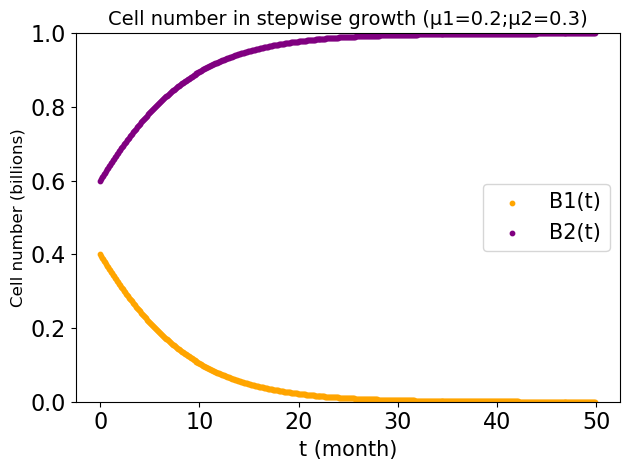

In [43]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.154]
Fluxes2_list=[0.346]

b1_list=[0.154]
b2_list=[0.346]

RequiredXproduction_list=[0.625]
RequiredYproduction_list=[0.417]

Bias_list=[0.05]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = [0.4]
B2_vals = [0.6]

def B1(t):
    if t <= 0:
        return 0.4
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]

def B2(t):
    if t <= 0:
        return 0.6
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]

for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    
    b1=0.5*0.2*B1_vals[-1]/(0.2*B1_vals[-1]+0.3*B2_vals[-1])
    b2=0.5*0.3*B2_vals[-1]/(0.2*B1_vals[-1]+0.3*B2_vals[-1])
    b1_list.append(b1)
    b2_list.append(b2)
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.DI1X.upper_bound=0.3
    model2.reactions.DI2Y.upper_bound=0.3
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['DI1X']
    Fluxes4=sol.fluxes.loc['DI2Y']
    Fluxes5=sol.fluxes.loc['EX_glucose_e']
    Bias=(Fluxes2-Fluxes1)/2
    RequiredXproduction=Fluxes3/B1_vals[-1]
    RequiredYproduction=Fluxes4/B2_vals[-1]
    RequiredXproduction_list.append(RequiredXproduction)
    RequiredYproduction_list.append(RequiredYproduction)
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Bias_list.append(Bias)

    T=t/10
    T_list.append(T)

plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,b1_list,color='orange',s=10)
# plt.scatter(T_list,b2_list,color='purple',s=10)

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,RequiredXproduction_list,color='red',s=10)
# plt.scatter(T_list,RequiredYproduction_list,color='green',s=10)

# plt.scatter(T_list,Bias_list,color='red',s=10)

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)','b2(t)'],loc='center right')

plt.xlabel("t (month)",fontsize=15)

plt.ylim(0,1)
plt.title('Cell number in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=14)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)'],loc='center right')

# plt.ylim(0,3)
# plt.title('Stepwise growth (µ1=0.2;µ2=0.3)',fontsize=14)
# plt.ylabel("(required relative) flux (m C-Molar or fold excess)",fontsize=12)
# plt.legend(['b1(t)','b2(t)','Required X\nproduction ability','Required Y\nproduction ability'],loc='center right',fontsize=12)

# plt.ylim(0,0.25)
# plt.title('Actual growth rate bias (µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("Actual growth bias value (m C-Molar)",fontsize=12)
# plt.legend(["$\u03B2$(t)"], loc="center right", fontsize=12)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()

# plt.show()
plt.savefig('Two cell lines (Stepwise growth)(Obj=b1+b2)',dpi=600)

In [31]:
import pandas as pd
df1 = pd.DataFrame(columns=['Cell1 number'])
df2 = pd.DataFrame(columns=['Cell2 number'])
df3 = pd.DataFrame(columns=['b1'])
df4 = pd.DataFrame(columns=['b2'])
df5 = pd.DataFrame(columns=['b1(E)'])
df6 = pd.DataFrame(columns=['b2(E)'])
for i in range(500):
    df1.loc[i] = B1_vals[i]
    df2.loc[i] = B2_vals[i]
    df3.loc[i] = Fluxes1_list[i]
    df4.loc[i] = Fluxes2_list[i] 
    df5.loc[i] = b1_list[i]
    df6.loc[i] = b2_list[i]
writer1 = pd.ExcelWriter("cell type1.xlsx")
writer2 = pd.ExcelWriter("cell type2.xlsx")
writer3 = pd.ExcelWriter("b1.xlsx")
writer4= pd.ExcelWriter("b2.xlsx")
writer5 = pd.ExcelWriter("b1(E).xlsx")
writer6 = pd.ExcelWriter("b2(E).xlsx")
df1.to_excel(writer1, sheet_name="Cell1")
df2.to_excel(writer2, sheet_name="Cell2")
df3.to_excel(writer3, sheet_name="Cell11")
df4.to_excel(writer4, sheet_name="Cell22")
df5.to_excel(writer5, sheet_name="Cell111")
df6.to_excel(writer6, sheet_name="Cell222")

writer1.save()
writer2.save()
writer3.save()
writer4.save()
writer5.save()
writer6.save()
writer1.close()
writer2.close()
writer3.close()
writer4.close()
writer5.close()
writer6.close()

/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_28216/3941415958.py:28: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer1.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_28216/3941415958.py:29: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer2.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_28216/3941415958.py:30: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer3.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_28216/3941415958.py:31: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer4.save()
/var/folders/d7/l6g7ly057s9bcdclxhvjs64h0000gn/T/ipykernel_28216/3941415958.py:32: Futur

<Figure size 640x480 with 0 Axes>

(0.0, 5.0)

Text(0.5, 1.0, 'biomass synthesis rate in stepwise growth (µ1=0.2;µ2=0.3)')

Text(0, 0.5, 'biomass synthesis rate')

Text(0.5, 0, 't (h)')

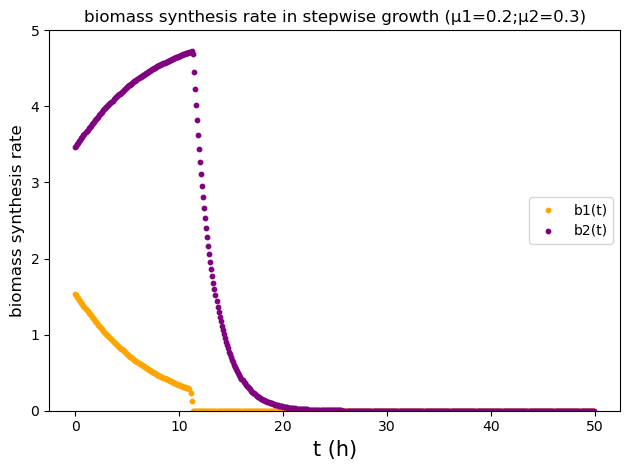

In [7]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[]
Fluxes1_list=[]
Fluxes2_list=[]

b1_list=[]
b2_list=[]

RequiredXproduction_list=[]
RequiredYproduction_list=[]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = []
B2_vals = []

def B1(t):
    if t <= 0:
        return 4
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]

def B2(t):
    if t <= 0:
        return 6
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]

for t in np.arange(0,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    b1=5*0.2*B1_vals[-1]/(0.2*B1_vals[-1]+0.3*B2_vals[-1])
    b2=5*0.3*B2_vals[-1]/(0.2*B1_vals[-1]+0.3*B2_vals[-1])
    b1_list.append(b1)
    b2_list.append(b2)
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['DI1X']
    Fluxes4=sol.fluxes.loc['DI2Y']
    Fluxes5=sol.fluxes.loc['EX_glucose_e']
    RequiredXproduction=Fluxes3/B1_vals[-1]
    RequiredYproduction=Fluxes4/B2_vals[-1]
    RequiredXproduction_list.append(RequiredXproduction)
    RequiredYproduction_list.append(RequiredYproduction)
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)

    T=t/10
    T_list.append(T)

# plt.scatter(T_list,B1_vals,color='orange',s=10)
# plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,b1_list,color='orange',s=10)
# plt.scatter(T_list,b2_list,color='purple',s=10)

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,RequiredXproduction_list,color='red',s=10)
# plt.scatter(T_list,RequiredYproduction_list,color='green',s=10)

plt.ylim(0,5)
plt.title('biomass synthesis rate in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
plt.ylabel("biomass synthesis rate",fontsize=12)
plt.legend(['b1(t)','b2(t)'],loc='center right')


plt.xlabel("t (h)",fontsize=15)

# plt.ylim(0,1)
# plt.title('Cell number in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("Cell number",fontsize=12)
# plt.legend(['B1(t)','B2(t)'],loc='center right')

# plt.ylim(0,3)
# plt.title('Required X and Y production per unit biomass and related\nbiomass synthesis fluxes in stepwise growth(µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("biomass synthesis rate or\nrequired production ability for X and Y",fontsize=12)
# plt.legend(['b1(t)','b2(t)','Required X\nproduction ability','Required Y\nproduction ability'],loc='center right',fontsize=12)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()

plt.show()
# plt.savefig('Two cell lines (Stepwise growth)(Obj=b1+b2)',dpi=300)

In [128]:
model1=model2.copy()
model3=model2.copy()

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 't (h)')

(0.0, 5.0)

Text(0.5, 1.0, 'biomass synthesis rate in stepwise growth (µ1=0.2;µ2=0.3)')

Text(0, 0.5, 'biomass synthesis rate')

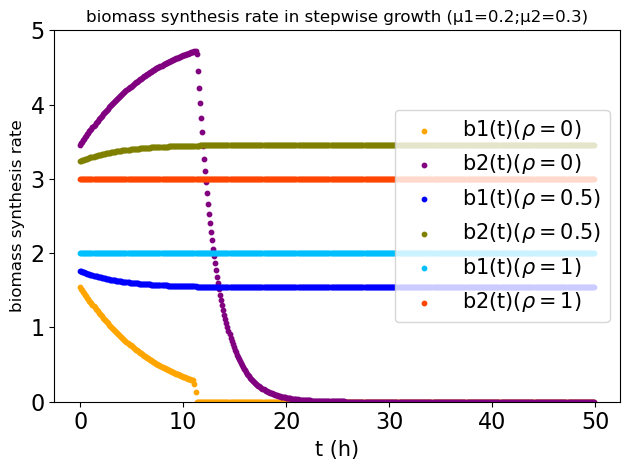

In [131]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[]
# Store the values of B1 and B2 for each time step in lists.
B1RS1_vals = []
B2RS1_vals = []

B1RS2_vals=[]
B2RS2_vals=[]
B1RS3_vals=[]
B2RS3_vals=[]

FluxesS1_list=[]
FluxesS2_list=[]
Fluxes1SR1_list=[]
Fluxes2SR1_list=[]
Fluxes1SR2_list=[]
Fluxes2SR2_list=[]

### define actual biomass
def B1RS1(t):
    if(t<=0):
        return 4
    return B1RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS1_list[-1]
def B2RS1(t):
    if(t<=0):
        return 6
    return B2RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS2_list[-1]
def B1RS2(t):
    if(t<=0):
        return 4
    return B1RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR1_list[-1]
def B2RS2(t):
    if(t<=0):
        return 6
    return B2RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR1_list[-1]
def B1RS3(t):
    if(t<=0):
        return 4
    return B1RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR2_list[-1]
def B2RS3(t):
    if(t<=0):
        return 6
    return B2RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR2_list[-1]

for t in np.arange(0,500,1):
    B1RS1_t = B1RS1(t)
    B2RS1_t = B2RS1(t)
    B1RS2_t = B1RS2(t)
    B2RS2_t = B2RS2(t)
    B1RS3_t = B1RS3(t)
    B2RS3_t = B2RS3(t)
    
    B1RS1_vals.append(B1RS1_t)
    B2RS1_vals.append(B2RS1_t)
    B1RS2_vals.append(B1RS2_t)
    B2RS2_vals.append(B2RS2_t)
    B1RS3_vals.append(B1RS3_t)
    B2RS3_vals.append(B2RS3_t)
    
    b1RS1=5*0.2*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)/(0.2*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.3*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b2RS1=5*0.3*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0)/(0.2*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.3*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b1RS2=5*0.2*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)/(0.2*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)+0.3*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5))
    b2RS2=5*0.3*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5)/(0.2*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)+0.3*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5))
    b1RS3=5*0.2*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)/(0.2*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)+0.3*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1))
    b2RS3=5*0.3*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1)/(0.2*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)+0.3*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1))
    
#     B1RS1_vals.append(B1RS1_t)
#     B2RS1_vals.append(B2RS1_t)
#     B1RS2_vals.append(B1RS2_t)
#     B2RS2_vals.append(B2RS2_t)
#     B1RS3_vals.append(B1RS3_t)
#     B2RS3_vals.append(B2RS3_t)
    
    model1.reactions.biomass1.upper_bound=b1RS1
    model1.reactions.biomass2.upper_bound=b2RS1
    model1.reactions.DI1X.upper_bound=3*B1RS1_vals[-1]
    model1.reactions.DI2Y.upper_bound=3*B2RS1_vals[-1]
    ### For regulation power=0.5
    model2.reactions.biomass1.upper_bound=b1RS2
    model2.reactions.biomass2.upper_bound=b2RS2
    model2.reactions.DI1X.upper_bound=3*B1RS2_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2RS2_vals[-1]
 ### For regulation power=1
    model3.reactions.biomass1.upper_bound=b1RS3
    model3.reactions.biomass2.upper_bound=b2RS3
    model3.reactions.DI1X.upper_bound=3*B1RS3_vals[-1]
    model3.reactions.DI2Y.upper_bound=3*B2RS3_vals[-1]
        
    sol1 = model1.optimize()
    obj_val = sol1.objective_value
    FluxesS1=sol1.fluxes.loc['biomass1']
    FluxesS2=sol1.fluxes.loc['biomass2']
    sol2 = model2.optimize()
    obj_val = sol2.objective_value
    Fluxes1SR1=sol2.fluxes.loc['biomass1']
    Fluxes2SR1=sol2.fluxes.loc['biomass2']
    sol3 = model3.optimize()
    obj_val = sol3.objective_value
    Fluxes1SR2=sol3.fluxes.loc['biomass1']
    Fluxes2SR2=sol3.fluxes.loc['biomass2']
        
    FluxesS1_list.append(FluxesS1)
    FluxesS2_list.append(FluxesS2)
    Fluxes1SR1_list.append(Fluxes1SR1)
    Fluxes2SR1_list.append(Fluxes2SR1)
    Fluxes1SR2_list.append(Fluxes1SR2)
    Fluxes2SR2_list.append(Fluxes2SR2)
    
    T=t/10
    T_list.append(T)
# print(FluxesS1_list[0],FluxesS2_list[0],Fluxes1SR1_list[0],Fluxes2SR1_list[0],Fluxes1SR2_list[0],Fluxes2SR2_list[0])
# plt.scatter(T_list,B1RS1_vals,color='orange',s=10)
# plt.scatter(T_list,B2RS1_vals,color='purple',s=10)
# plt.scatter(T_list,B1RS2_vals,color='blue',s=10)
# plt.scatter(T_list,B2RS2_vals,color='olive',s=10)
# plt.scatter(T_list,B1RS3_vals,color='deepskyblue',s=10)
# plt.scatter(T_list,B2RS3_vals,color='orangered',s=10)

plt.scatter(T_list,FluxesS1_list,color='orange',s=10)
plt.scatter(T_list,FluxesS2_list,color='purple',s=10)
plt.scatter(T_list,Fluxes1SR1_list,color='blue',s=10)
plt.scatter(T_list,Fluxes2SR1_list,color='olive',s=10)
plt.scatter(T_list,Fluxes1SR2_list,color='deepskyblue',s=10)
plt.scatter(T_list,Fluxes2SR2_list,color='orangered',s=10)

plt.xlabel("t (h)",fontsize=15)


# plt.ylim(0,1)
# plt.title('Cell number in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("Cell number",fontsize=12)
# plt.legend(['B1(t)''('r'$\rho=0$'')','B2(t)''('r'$\rho=0$'')','B1(t)''('r'$\rho=0.5$'')',
#             'B2(t)''('r'$\rho=0.5$'')','B1(t)''('r'$\rho=1$'')','B2(t)''('r'$\rho=1$'')'],
#            loc='center right')

plt.ylim(0,5)
plt.title('biomass synthesis rate in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
plt.ylabel("biomass synthesis rate",fontsize=12)
plt.legend(['b1(t)''('r'$\rho=0$'')','b2(t)''('r'$\rho=0$'')','b1(t)''('r'$\rho=0.5$'')',
            'b2(t)''('r'$\rho=0.5$'')','b1(t)''('r'$\rho=1$'')','b2(t)''('r'$\rho=1$'')'],
           loc='center right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15


plt.tight_layout()
plt.show()
# plt.savefig('Biomass synthesis value for exponential growth with normal regulation',dpi=300)
# plt.savefig('Biomass value for exponential growth with regulation',dpi=300)

### µ1=0.15; µ2=0.35

In [49]:
model2=model.copy()

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 't (month)')

(0.0, 3.0)

Text(0.5, 1.0, 'Stepwise growth (µ1=0.15;µ2=0.35)')

Text(0, 0.5, '(required relative) flux (m C-Molar or fold excess)')

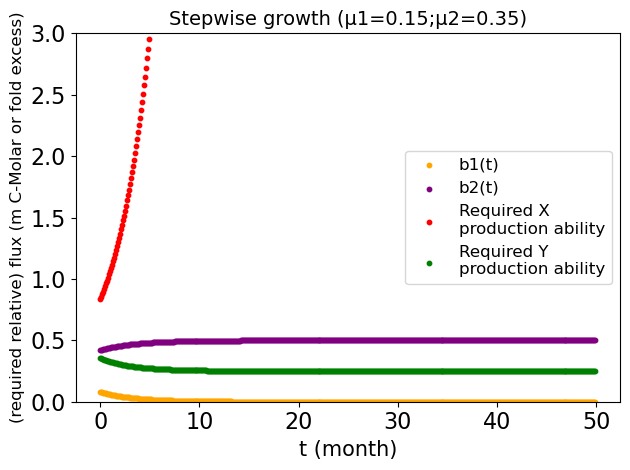

In [50]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.0776]
Fluxes2_list=[0.4224]
b1_list=[0.0776]
b2_list=[0.4224]

RequiredXproduction_list=[0.833]
RequiredYproduction_list=[0.3571]

Bias_list=[0.1]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = [0.3]
B2_vals = [0.7]

def B1(t):
    if t <= 0:
        return 0.3
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]

def B2(t):
    if t <= 0:
        return 0.7
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]

for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    

    b1=0.5*0.15*B1_vals[-1]/(0.15*B1_vals[-1]+0.35*B2_vals[-1])
    b2=0.5*0.35*B2_vals[-1]/(0.15*B1_vals[-1]+0.35*B2_vals[-1])
    b1_list.append(b1)
    b2_list.append(b2)
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)

    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.DI1X.upper_bound=3
    model2.reactions.DI2Y.upper_bound=3
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['DI1X']
    Fluxes4=sol.fluxes.loc['DI2Y']
    Fluxes5=sol.fluxes.loc['EX_glucose_e']
    Bias=(Fluxes2-Fluxes1)/2
    RequiredXproduction=Fluxes3/B1_t
    RequiredYproduction=Fluxes4/B2_t
    RequiredXproduction_list.append(RequiredXproduction)
    RequiredYproduction_list.append(RequiredYproduction)
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Bias_list.append(Bias)

    T=t/10
    T_list.append(T)
# plt.scatter(T_list,B1_vals,color='orange',s=10)
# plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,b1_list,color='orange',s=10)
# plt.scatter(T_list,b2_list,color='purple',s=10)

plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
plt.scatter(T_list,RequiredXproduction_list,color='red',s=10)
plt.scatter(T_list,RequiredYproduction_list,color='green',s=10)

# plt.scatter(T_list,Bias_list,color='red',s=10)

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in stepwise growth (µ1=0.15;µ2=0.35)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)','b2(t)'],loc='center right')


plt.xlabel("t (month)",fontsize=15)

# plt.ylim(0,1)
# plt.title('Cell number in stepwise growth (µ1=0.15;µ2=0.35)',fontsize=14)
# plt.ylabel("Cell number (billions)",fontsize=12)
# plt.legend(['B1(t)','B2(t)'],loc='center right')

plt.ylim(0,3)
plt.title('Stepwise growth (µ1=0.15;µ2=0.35)',fontsize=14)
plt.ylabel("(required relative) flux (m C-Molar or fold excess)",fontsize=12)
plt.legend(['b1(t)','b2(t)','Required X\nproduction ability','Required Y\nproduction ability'],loc='center right',fontsize=12)

# plt.ylim(0,0.25)
# plt.title('Actual growth rate bias (µ1=0.15;µ2=0.35)',fontsize=12)
# plt.ylabel("Actual growth bias value (m C-Molar)",fontsize=12)
# plt.legend(["$\u03B2$(t)"], loc="center right", fontsize=12)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()

# plt.show()
plt.savefig('Two cell lines (Stepwise growth)(Obj=b1+b2)',dpi=600)

### µ1=0.05; µ2=0.45

In [55]:
model2=model.copy()

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Cell number in stepwise growth (µ1=0.05;µ2=0.45)')

Text(0, 0.5, 'Cell number (billions)')

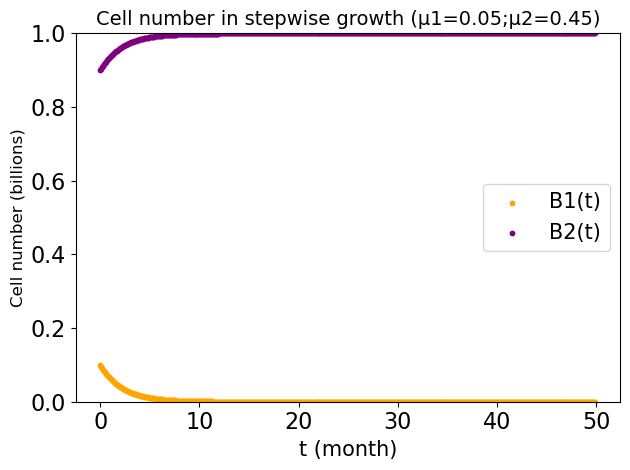

In [56]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.0061]
Fluxes2_list=[0.4939]
b1_list=[0.0061]
b2_list=[0.4939]

RequiredXproduction_list=[2.5]
RequiredYproduction_list=[0.2778]

Bias_list=[0.2]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = [0.1]
B2_vals = [0.9]

def B1(t):
    if t <= 0:
        return 0.1
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]

def B2(t):
    if t <= 0:
        return 0.9
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]

for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)

    b1=0.5*0.05*B1_vals[-1]/(0.05*B1_vals[-1]+0.45*B2_vals[-1])
    b2=0.5*0.45*B2_vals[-1]/(0.05*B1_vals[-1]+0.45*B2_vals[-1])
    b1_list.append(b1)
    b2_list.append(b2)
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)

    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.DI1X.upper_bound=3
    model2.reactions.DI2Y.upper_bound=3
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['DI1X']
    Fluxes4=sol.fluxes.loc['DI2Y']
    Fluxes5=sol.fluxes.loc['EX_glucose_e']
    Bias=(Fluxes2-Fluxes1)/2
    RequiredXproduction=Fluxes3/B1_t
    RequiredYproduction=Fluxes4/B2_t
    RequiredXproduction_list.append(RequiredXproduction)
    RequiredYproduction_list.append(RequiredYproduction)
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Bias_list.append(Bias)

    T=t/10
    T_list.append(T)

plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,b1_list,color='orange',s=10)
# plt.scatter(T_list,b2_list,color='purple',s=10)

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,RequiredXproduction_list,color='red',s=10)
# plt.scatter(T_list,RequiredYproduction_list,color='green',s=10)

# plt.scatter(T_list,Bias_list,color='red',s=10)

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in stepwise growth (µ1=0.05;µ2=0.45)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)','b2(t)'],loc='center right')


plt.xlabel("t (month)",fontsize=15)

plt.ylim(0,1)
plt.title('Cell number in stepwise growth (µ1=0.05;µ2=0.45)',fontsize=14)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)'],loc='center right')

# plt.ylim(0,3)
# plt.title('Stepwise growth (µ1=0.05;µ2=0.45)',fontsize=14)
# plt.ylabel("(required relative) flux (m C-Molar or fold excess)",fontsize=12)
# plt.legend(['b1(t)','b2(t)','Required X\nproduction ability','Required Y\nproduction ability'],loc='center right',fontsize=12)

# plt.ylim(0,0.25)
# plt.title('Actual growth rate bias (µ1=0.05;µ2=0.45)',fontsize=12)
# plt.ylabel("Actual growth bias value (m C-Molar)",fontsize=12)
# plt.legend(["$\u03B2$(t)"], loc="center right", fontsize=12)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()

# plt.show()
plt.savefig('Two cell lines (Stepwise growth)(Obj=b1+b2)',dpi=600)

## Growing with time (Stepwise growth) for different death rate and growth rate

### µ1=0.2; µ2=0.3; kD1=0.4, kD2=0.6

In [58]:
model3=model.copy()

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Cell number in stepwise growth (µ1/kD1=µ2/kD2)')

Text(0, 0.5, 'Cell number (billions)')

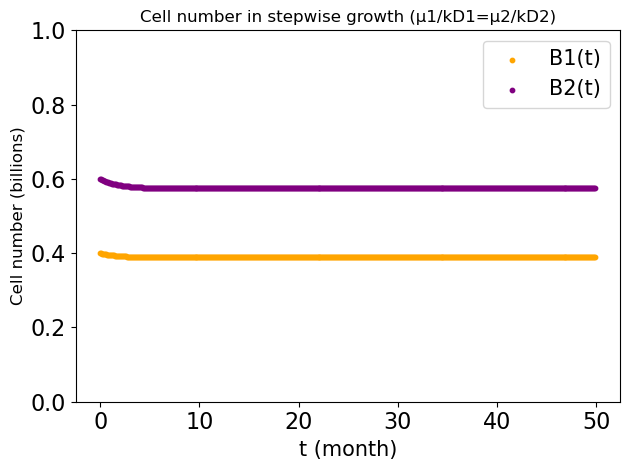

In [59]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.154]
Fluxes2_list=[0.346]

b1_list=[0.154]
b2_list=[0.346]

RequiredXproduction_list=[0.625]
RequiredYproduction_list=[0.417]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = [0.4]
B2_vals = [0.6]

def B1(t):
    if t <= 0:
        return 0.4
    return B1_vals[int((t-1)/1)]*0.96+0.1*Fluxes1_list[-1]

def B2(t):
    if t <= 0:
        return 0.6
    return B2_vals[int((t-1)/1)]*0.94+0.1*Fluxes2_list[-1]
for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    
    b1=0.5*0.2*B1_vals[-1]/(0.2*B1_vals[-1]+0.3*B2_vals[-1])
    b2=0.5*0.3*B2_vals[-1]/(0.2*B1_vals[-1]+0.3*B2_vals[-1])
    b1_list.append(b1)
    b2_list.append(b2)
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)

    model3.reactions.biomass1.upper_bound=b1
    model3.reactions.biomass2.upper_bound=b2
    model3.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model3.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    sol = model3.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['DI1X']
    Fluxes4=sol.fluxes.loc['DI2Y']
    Fluxes5=sol.fluxes.loc['EX_glucose_e']
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)

    T=t/10
    T_list.append(T)

plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)

plt.xlabel("t (month)",fontsize=15)


plt.ylim(0,1)
plt.title('Cell number in stepwise growth (µ1/kD1=µ2/kD2)',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)'],loc='upper right')

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in stepwise growth (µ1/kD1=µ2/kD2)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)','b2(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()

# plt.show()
plt.savefig('Two cell lines (Stepwise growth)(Obj=b1+b2))',dpi=600)

### µ1=0.15; µ2=0.35; kD1=0.3, kD2=0.7

In [64]:
model3=model.copy()

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Cell number in stepwise growth (µ1/kD1=µ2/kD2)')

Text(0, 0.5, 'Cell number (billions)')

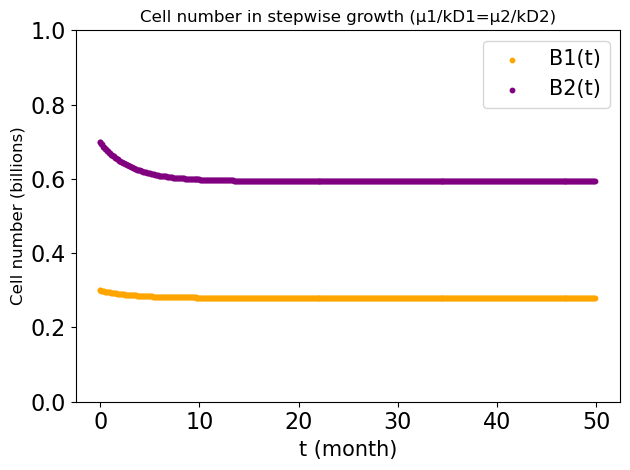

In [65]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.0776]
Fluxes2_list=[0.4224]
b1_list=[0.0776]
b2_list=[0.4224]

RequiredXproduction_list=[0.833]
RequiredYproduction_list=[0.3571]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = [0.3]
B2_vals = [0.7]

def B1(t):
    if t <= 0:
        return 0.3
    return B1_vals[int((t-1)/1)]*0.97+0.1*Fluxes1_list[-1]

def B2(t):
    if t <= 0:
        return 0.7
    return B2_vals[int((t-1)/1)]*0.93+0.1*Fluxes2_list[-1]
for t in np.arange(0,500,1):
    B1_t = B1(t)
    B2_t = B2(t)

    b1=0.5*0.15*B1_vals[-1]/(0.15*B1_vals[-1]+0.35*B2_vals[-1])
    b2=0.5*0.35*B2_vals[-1]/(0.15*B1_vals[-1]+0.35*B2_vals[-1])
    b1_list.append(b1)
    b2_list.append(b2)
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    
    model3.reactions.biomass1.upper_bound=b1
    model3.reactions.biomass2.upper_bound=b2
    model3.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model3.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    sol = model3.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['DI1X']
    Fluxes4=sol.fluxes.loc['DI2Y']
    Fluxes5=sol.fluxes.loc['EX_glucose_e']
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)

    T=t/10
    T_list.append(T)


plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)

plt.xlabel("t (month)",fontsize=15)


plt.ylim(0,1)
plt.title('Cell number in stepwise growth (µ1/kD1=µ2/kD2)',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)'],loc='upper right')

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in stepwise growth (µ1/kD1=µ2/kD2)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)','b2(t)'],loc='center right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()

# plt.show()
plt.savefig('Two cell lines (Stepwise growth)(Obj=b1+b2))',dpi=600)

### µ1=0.05; µ2=0.45; kD1=0.1, kD2=0.9

In [66]:
model3=model.copy()

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Cell number in stepwise growth (µ1/kD1=µ2/kD2)')

Text(0, 0.5, 'Cell number (billions)')

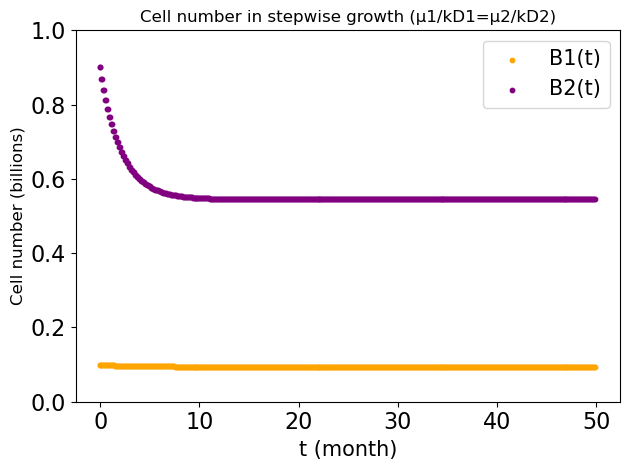

In [67]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.0061]
Fluxes2_list=[0.4939]
b1_list=[0.0061]
b2_list=[0.4939]

RequiredXproduction_list=[2.5]
RequiredYproduction_list=[0.2778]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = [0.1]
B2_vals = [0.9]

def B1(t):
    if t <= 0:
        return 0.1
    return B1_vals[int((t-1)/1)]*0.99+0.1*Fluxes1_list[-1]

def B2(t):
    if t <= 0:
        return 0.9
    return B2_vals[int((t-1)/1)]*0.91+0.1*Fluxes2_list[-1]
for t in np.arange(0,500,1):
    B1_t = B1(t)
    B2_t = B2(t)

    b1=0.5*0.05*B1_vals[-1]/(0.05*B1_vals[-1]+0.45*B2_vals[-1])
    b2=0.5*0.45*B2_vals[-1]/(0.05*B1_vals[-1]+0.45*B2_vals[-1])
    b1_list.append(b1)
    b2_list.append(b2)
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    
    model3.reactions.biomass1.upper_bound=b1
    model3.reactions.biomass2.upper_bound=b2
    model3.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model3.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    sol = model3.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['DI1X']
    Fluxes4=sol.fluxes.loc['DI2Y']
    Fluxes5=sol.fluxes.loc['EX_glucose_e']
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)

    T=t/10
    T_list.append(T)

plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
plt.xlabel("t (month)",fontsize=15)


plt.ylim(0,1)
plt.title('Cell number in stepwise growth (µ1/kD1=µ2/kD2)',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)'],loc='upper right')

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in stepwise growth (µ1/kD1=µ2/kD2)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)','b2(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()

# plt.show()
plt.savefig('Two cell lines (Stepwise growth)(Obj=b1+b2))',dpi=600)

# With regulation

## Exponential growth with regulation (biomass synthesis relating to cell number from others)

### µ1=0.2; µ2=0.3

In [68]:
from cobra.flux_analysis import pfba
# import map visualization tools
from utils import show_map
import escher
map_loc = 'Two cell system model_map.json' # the escher map used below
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load Recon3DModel with a simplified medium for the course
M = cobra.io.load_json_model('Two cell system model.json')
model = M.copy()

In [69]:
### Internal goods X and Y
model1=model.copy()
model1.reactions.EX_Com_goodX_e.lower_bound=0
model1.reactions.EX_Com_goodY_e.lower_bound=0
model1.reactions.EX_glucose_e.lower_bound=-1
model2=model1.copy()
model3=model1.copy()

<Figure size 640x480 with 0 Axes>

0.2 0.3 0.2247 0.2753 0.25 0.25


Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Cell number in exponential growth (µ1=0.2;µ2=0.3)')

Text(0, 0.5, 'Cell number (billions)')

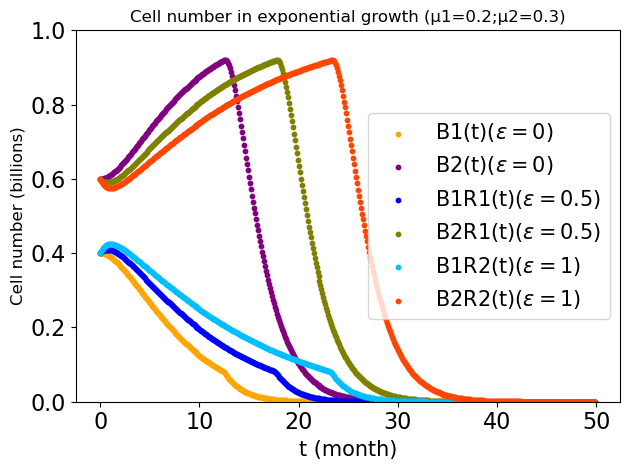

In [70]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = [0.4]
B2_vals = [0.6]

B1R1_vals=[0.4]
B2R1_vals=[0.6]
B1R2_vals=[0.4]
B2R2_vals=[0.6]

Fluxes1_list=[0.2]
Fluxes2_list=[0.3]
Fluxes1R1_list=[0.2247]
Fluxes2R1_list=[0.2753]
Fluxes1R2_list=[0.25]
Fluxes2R2_list=[0.25]

### define actual biomass
def B1(t):
    if(t<=0):
        return 0.4
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.6
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B1R1(t):
    if(t<=0):
        return 0.4
    return B1R1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1R1_list[-1]
def B2R1(t):
    if(t<=0):
        return 0.6
    return B2R1_vals[int((t-1)/1)]*0.95+0.1*Fluxes2R1_list[-1]
def B1R2(t):
    if(t<=0):
        return 0.4
    return B1R2_vals[int((t-1)/1)]*0.95+0.1*Fluxes1R2_list[-1]
def B2R2(t):
    if(t<=0):
        return 0.6
    return B2R2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2R2_list[-1]

for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B1R1_t = B1R1(t)
    B2R1_t = B2R1(t)
    B1R2_t = B1R2(t)
    B2R2_t = B2R2(t)
    
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B1R1_vals.append(B1R1_t)
#     B2R1_vals.append(B2R1_t)
#     B1R2_vals.append(B1R2_t)
#     B2R2_vals.append(B2R2_t)
    
    b1=0.5*0.2*math.exp(0.2*t/10/0.5)/(0.2*math.exp(0.2*t/10/0.5)+0.3*math.exp(0.3*t/10/0.5))
    b2=0.5*0.3*math.exp(0.3*t/10/0.5)/(0.2*math.exp(0.2*t/10/0.5)+0.3*math.exp(0.3*t/10/0.5))
    b1R1=0.5*0.2*math.exp(0.2*t/10/0.5)*math.pow(B2R1_vals[-1],0.5)/(0.2*math.exp(0.2*t/10/0.5)*math.pow(B2R1_vals[-1],0.5)+0.3*math.exp(0.3*t/10/0.5)*math.pow(B1R1_vals[-1],0.5))
    b2R1=0.5*0.3*math.exp(0.3*t/10/0.5)*math.pow(B1R1_vals[-1],0.5)/(0.2*math.exp(0.2*t/10/0.5)*math.pow(B2R1_vals[-1],0.5)+0.3*math.exp(0.3*t/10/0.5)*math.pow(B1R1_vals[-1],0.5))
    b1R2=0.5*0.2*math.exp(0.2*t/10/0.5)*math.pow(B2R2_vals[-1],1)/(0.2*math.exp(0.2*t/10/0.5)*math.pow(B2R2_vals[-1],1)+0.3*math.exp(0.3*t/10/0.5)*math.pow(B1R2_vals[-1],1))
    b2R2=0.5*0.3*math.exp(0.3*t/10/0.5)*math.pow(B1R2_vals[-1],1)/(0.2*math.exp(0.2*t/10/0.5)*math.pow(B2R2_vals[-1],1)+0.3*math.exp(0.3*t/10/0.5)*math.pow(B1R2_vals[-1],1))
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B1R1_vals.append(B1R1_t)
    B2R1_vals.append(B2R1_t)
    B1R2_vals.append(B1R2_t)
    B2R2_vals.append(B2R2_t)
    
    model1.reactions.biomass1.upper_bound=b1
    model1.reactions.biomass2.upper_bound=b2
    model1.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model1.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    ### For regulation power=0.5
    model2.reactions.biomass1.upper_bound=b1R1
    model2.reactions.biomass2.upper_bound=b2R1
    model2.reactions.DI1X.upper_bound=3*B1R1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2R1_vals[-1]
 ### For regulation power=1
    model3.reactions.biomass1.upper_bound=b1R2
    model3.reactions.biomass2.upper_bound=b2R2
    model3.reactions.DI1X.upper_bound=3*B1R2_vals[-1]
    model3.reactions.DI2Y.upper_bound=3*B2R2_vals[-1]
        
    sol1 = model1.optimize()
    obj_val = sol1.objective_value
    Fluxes1=sol1.fluxes.loc['biomass1']
    Fluxes2=sol1.fluxes.loc['biomass2']
    sol2 = model2.optimize()
    obj_val = sol2.objective_value
    Fluxes1R1=sol2.fluxes.loc['biomass1']
    Fluxes2R1=sol2.fluxes.loc['biomass2']
    sol3 = model3.optimize()
    obj_val = sol3.objective_value
    Fluxes1R2=sol3.fluxes.loc['biomass1']
    Fluxes2R2=sol3.fluxes.loc['biomass2']
        
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes1R1_list.append(Fluxes1R1)
    Fluxes2R1_list.append(Fluxes2R1)
    Fluxes1R2_list.append(Fluxes1R2)
    Fluxes2R2_list.append(Fluxes2R2)
    
    T=t/10
    T_list.append(T)
    
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes1R1_list[0],Fluxes2R1_list[0],Fluxes1R2_list[0],Fluxes2R2_list[0])

plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B1R1_vals,color='blue',s=10)
plt.scatter(T_list,B2R1_vals,color='olive',s=10)
plt.scatter(T_list,B1R2_vals,color='deepskyblue',s=10)
plt.scatter(T_list,B2R2_vals,color='orangered',s=10)

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes1R1_list,color='blue',s=10)
# plt.scatter(T_list,Fluxes2R1_list,color='olive',s=10)
# plt.scatter(T_list,Fluxes1R2_list,color='deepskyblue',s=10)
# plt.scatter(T_list,Fluxes2R2_list,color='orangered',s=10)

plt.xlabel("t (month)",fontsize=15)


plt.ylim(0,1)
plt.title('Cell number in exponential growth (µ1=0.2;µ2=0.3)',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)''('r'$\varepsilon=0$'')','B2(t)''('r'$\varepsilon=0$'')','B1R1(t)''('r'$\varepsilon=0.5$'')',
            'B2R1(t)''('r'$\varepsilon=0.5$'')','B1R2(t)''('r'$\varepsilon=1$'')','B2R2(t)''('r'$\varepsilon=1$'')'],
           loc='center right')

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in exponential growth (µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)''('r'$\varepsilon=0$'')','b2(t)''('r'$\varepsilon=0$'')','b1R1(t)''('r'$\varepsilon=0.5$'')',
#             'b2R1(t)''('r'$\varepsilon=0.5$'')','b1R2(t)''('r'$\varepsilon=1$'')','b2R2(t)''('r'$\varepsilon=1$'')'],
#            loc='center right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15


plt.tight_layout()
# plt.show()
plt.savefig('Biomass synthesis value for exponential growth with normal regulation',dpi=600)
# plt.savefig('Biomass value for exponential growth with regulation',dpi=300)

### µ1=0.15; µ2=0.35

In [71]:
from cobra.flux_analysis import pfba
# import map visualization tools
from utils import show_map
import escher
map_loc = 'Two cell system model_map.json' # the escher map used below
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load Recon3DModel with a simplified medium for the course
M = cobra.io.load_json_model('Two cell system model.json')
model = M.copy()

In [72]:
### Internal goods X and Y
model1=model.copy()
model1.reactions.EX_Com_goodX_e.lower_bound=0
model1.reactions.EX_Com_goodY_e.lower_bound=0
model1.reactions.EX_glucose_e.lower_bound=-1
model2=model1.copy()
model3=model1.copy()

<Figure size 640x480 with 0 Axes>

0.15 0.35 0.1978 0.3022 0.25 0.25


Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Cell number in exponential growth (µ1=0.15;µ2=0.35)')

Text(0, 0.5, 'Cell number (billions)')

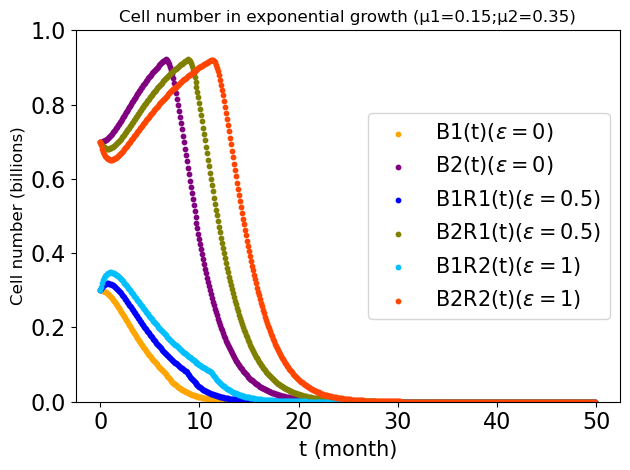

In [73]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = [0.3]
B2_vals = [0.7]

B1R1_vals=[0.3]
B2R1_vals=[0.7]
B1R2_vals=[0.3]
B2R2_vals=[0.7]

Fluxes1_list=[0.15]
Fluxes2_list=[0.35]
Fluxes1R1_list=[0.1978]
Fluxes2R1_list=[0.3022]
Fluxes1R2_list=[0.25]
Fluxes2R2_list=[0.25]

### define actual biomass
def B1(t):
    if(t<=0):
        return 0.3
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.7
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B1R1(t):
    if(t<=0):
        return 0.3
    return B1R1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1R1_list[-1]
def B2R1(t):
    if(t<=0):
        return 0.7
    return B2R1_vals[int((t-1)/1)]*0.95+0.1*Fluxes2R1_list[-1]
def B1R2(t):
    if(t<=0):
        return 0.3
    return B1R2_vals[int((t-1)/1)]*0.95+0.1*Fluxes1R2_list[-1]
def B2R2(t):
    if(t<=0):
        return 0.7
    return B2R2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2R2_list[-1]

for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B1R1_t = B1R1(t)
    B2R1_t = B2R1(t)
    B1R2_t = B1R2(t)
    B2R2_t = B2R2(t)
    
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B1R1_vals.append(B1R1_t)
#     B2R1_vals.append(B2R1_t)
#     B1R2_vals.append(B1R2_t)
#     B2R2_vals.append(B2R2_t)
    
    b1=0.5*0.15*math.exp(0.15*t/10/0.5)/(0.15*math.exp(0.15*t/10/0.5)+0.35*math.exp(0.35*t/10/0.5))
    b2=0.5*0.35*math.exp(0.35*t/10/0.5)/(0.15*math.exp(0.15*t/10/0.5)+0.35*math.exp(0.35*t/10/0.5))
    b1R1=0.5*0.15*math.exp(0.15*t/10/0.5)*math.pow(B2R1_vals[-1],0.5)/(0.15*math.exp(0.15*t/10/0.5)*math.pow(B2R1_vals[-1],0.5)+0.35*math.exp(0.35*t/10/0.5)*math.pow(B1R1_vals[-1],0.5))
    b2R1=0.5*0.35*math.exp(0.35*t/10/0.5)*math.pow(B1R1_vals[-1],0.5)/(0.15*math.exp(0.15*t/10/0.5)*math.pow(B2R1_vals[-1],0.5)+0.35*math.exp(0.35*t/10/0.5)*math.pow(B1R1_vals[-1],0.5))
    b1R2=0.5*0.15*math.exp(0.15*t/10/0.5)*math.pow(B2R2_vals[-1],1)/(0.15*math.exp(0.15*t/10/0.5)*math.pow(B2R2_vals[-1],1)+0.35*math.exp(0.35*t/10/0.5)*math.pow(B1R2_vals[-1],1))
    b2R2=0.5*0.35*math.exp(0.35*t/10/0.5)*math.pow(B1R2_vals[-1],1)/(0.15*math.exp(0.15*t/10/0.5)*math.pow(B2R2_vals[-1],1)+0.35*math.exp(0.35*t/10/0.5)*math.pow(B1R2_vals[-1],1))
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B1R1_vals.append(B1R1_t)
    B2R1_vals.append(B2R1_t)
    B1R2_vals.append(B1R2_t)
    B2R2_vals.append(B2R2_t)
    
    model1.reactions.biomass1.upper_bound=b1
    model1.reactions.biomass2.upper_bound=b2
    model1.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model1.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    ### For regulation power=0.5
    model2.reactions.biomass1.upper_bound=b1R1
    model2.reactions.biomass2.upper_bound=b2R1
    model2.reactions.DI1X.upper_bound=3*B1R1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2R1_vals[-1]
 ### For regulation power=1
    model3.reactions.biomass1.upper_bound=b1R2
    model3.reactions.biomass2.upper_bound=b2R2
    model3.reactions.DI1X.upper_bound=3*B1R2_vals[-1]
    model3.reactions.DI2Y.upper_bound=3*B2R2_vals[-1]
        
    sol1 = model1.optimize()
    obj_val = sol1.objective_value
    Fluxes1=sol1.fluxes.loc['biomass1']
    Fluxes2=sol1.fluxes.loc['biomass2']
    sol2 = model2.optimize()
    obj_val = sol2.objective_value
    Fluxes1R1=sol2.fluxes.loc['biomass1']
    Fluxes2R1=sol2.fluxes.loc['biomass2']
    sol3 = model3.optimize()
    obj_val = sol3.objective_value
    Fluxes1R2=sol3.fluxes.loc['biomass1']
    Fluxes2R2=sol3.fluxes.loc['biomass2']
        
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes1R1_list.append(Fluxes1R1)
    Fluxes2R1_list.append(Fluxes2R1)
    Fluxes1R2_list.append(Fluxes1R2)
    Fluxes2R2_list.append(Fluxes2R2)
    
    T=t/10
    T_list.append(T)
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes1R1_list[0],Fluxes2R1_list[0],Fluxes1R2_list[0],Fluxes2R2_list[0])
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B1R1_vals,color='blue',s=10)
plt.scatter(T_list,B2R1_vals,color='olive',s=10)
plt.scatter(T_list,B1R2_vals,color='deepskyblue',s=10)
plt.scatter(T_list,B2R2_vals,color='orangered',s=10)

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes1R1_list,color='blue',s=10)
# plt.scatter(T_list,Fluxes2R1_list,color='olive',s=10)
# plt.scatter(T_list,Fluxes1R2_list,color='deepskyblue',s=10)
# plt.scatter(T_list,Fluxes2R2_list,color='orangered',s=10)

plt.xlabel("t (month)",fontsize=15)


plt.ylim(0,1)
plt.title('Cell number in exponential growth (µ1=0.15;µ2=0.35)',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)''('r'$\varepsilon=0$'')','B2(t)''('r'$\varepsilon=0$'')','B1R1(t)''('r'$\varepsilon=0.5$'')',
            'B2R1(t)''('r'$\varepsilon=0.5$'')','B1R2(t)''('r'$\varepsilon=1$'')','B2R2(t)''('r'$\varepsilon=1$'')'],
           loc='center right')

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in exponential growth (µ1=0.15;µ2=0.35)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)''('r'$\varepsilon=0$'')','b2(t)''('r'$\varepsilon=0$'')','b1R1(t)''('r'$\varepsilon=0.5$'')',
#             'b2R1(t)''('r'$\varepsilon=0.5$'')','b1R2(t)''('r'$\varepsilon=1$'')','b2R2(t)''('r'$\varepsilon=1$'')'],
#            loc='center right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15


plt.tight_layout()
# plt.show()
plt.savefig('Biomass synthesis value for exponential growth with normal regulation',dpi=600)
# plt.savefig('Biomass value for exponential growth with regulation',dpi=300)

### µ1=0.05; µ2=0.45

In [74]:
from cobra.flux_analysis import pfba
# import map visualization tools
from utils import show_map
import escher
map_loc = 'Two cell system model_map.json' # the escher map used below
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load Recon3DModel with a simplified medium for the course
M = cobra.io.load_json_model('Two cell system model.json')
model = M.copy()

In [75]:
### Internal goods X and Y
model1=model.copy()
model1.reactions.EX_Com_goodX_e.lower_bound=0
model1.reactions.EX_Com_goodY_e.lower_bound=0
model1.reactions.EX_glucose_e.lower_bound=-1
model2=model1.copy()
model3=model1.copy()

<Figure size 640x480 with 0 Axes>

0.05 0.45 0.125 0.375 0.25 0.25


Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Cell number in exponential growth (µ1=0.05;µ2=0.45)')

Text(0, 0.5, 'Cell number (billions)')

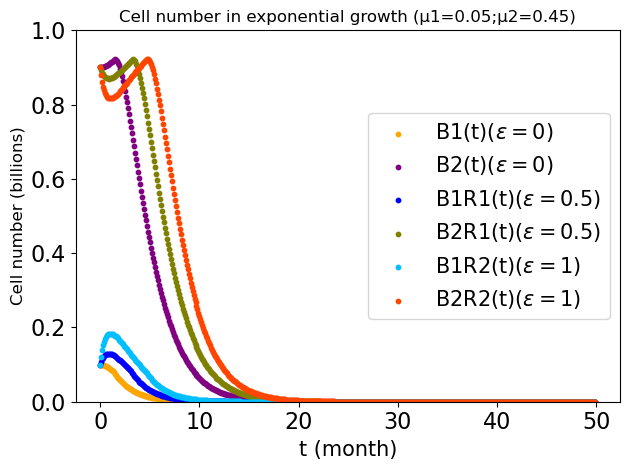

In [76]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = [0.1]
B2_vals = [0.9]

B1R1_vals=[0.1]
B2R1_vals=[0.9]
B1R2_vals=[0.1]
B2R2_vals=[0.9]

Fluxes1_list=[0.05]
Fluxes2_list=[0.45]
Fluxes1R1_list=[0.125]
Fluxes2R1_list=[0.375]
Fluxes1R2_list=[0.25]
Fluxes2R2_list=[0.25]

### define actual biomass
def B1(t):
    if(t<=0):
        return 0.1
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.9
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B1R1(t):
    if(t<=0):
        return 0.1
    return B1R1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1R1_list[-1]
def B2R1(t):
    if(t<=0):
        return 0.9
    return B2R1_vals[int((t-1)/1)]*0.95+0.1*Fluxes2R1_list[-1]
def B1R2(t):
    if(t<=0):
        return 0.1
    return B1R2_vals[int((t-1)/1)]*0.95+0.1*Fluxes1R2_list[-1]
def B2R2(t):
    if(t<=0):
        return 0.9
    return B2R2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2R2_list[-1]

for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B1R1_t = B1R1(t)
    B2R1_t = B2R1(t)
    B1R2_t = B1R2(t)
    B2R2_t = B2R2(t)
    
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B1R1_vals.append(B1R1_t)
#     B2R1_vals.append(B2R1_t)
#     B1R2_vals.append(B1R2_t)
#     B2R2_vals.append(B2R2_t)
    
    b1=0.5*0.05*math.exp(0.05*t/10/0.5)/(0.05*math.exp(0.05*t/10/0.5)+0.45*math.exp(0.45*t/10/0.5))
    b2=0.5*0.45*math.exp(0.45*t/10/0.5)/(0.05*math.exp(0.05*t/10/0.5)+0.45*math.exp(0.45*t/10/0.5))
    b1R1=0.5*0.05*math.exp(0.05*t/10/0.5)*math.pow(B2R1_vals[-1],0.5)/(0.05*math.exp(0.05*t/10/0.5)*math.pow(B2R1_vals[-1],0.5)+0.45*math.exp(0.45*t/10/0.5)*math.pow(B1R1_vals[-1],0.5))
    b2R1=0.5*0.45*math.exp(0.45*t/10/0.5)*math.pow(B1R1_vals[-1],0.5)/(0.05*math.exp(0.05*t/10/0.5)*math.pow(B2R1_vals[-1],0.5)+0.45*math.exp(0.45*t/10/0.5)*math.pow(B1R1_vals[-1],0.5))
    b1R2=0.5*0.05*math.exp(0.05*t/10/0.5)*math.pow(B2R2_vals[-1],1)/(0.05*math.exp(0.05*t/10/0.5)*math.pow(B2R2_vals[-1],1)+0.45*math.exp(0.45*t/10/0.5)*math.pow(B1R2_vals[-1],1))
    b2R2=0.5*0.45*math.exp(0.45*t/10/0.5)*math.pow(B1R2_vals[-1],1)/(0.05*math.exp(0.05*t/10/0.5)*math.pow(B2R2_vals[-1],1)+0.45*math.exp(0.45*t/10/0.5)*math.pow(B1R2_vals[-1],1))
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B1R1_vals.append(B1R1_t)
    B2R1_vals.append(B2R1_t)
    B1R2_vals.append(B1R2_t)
    B2R2_vals.append(B2R2_t)
    
    model1.reactions.biomass1.upper_bound=b1
    model1.reactions.biomass2.upper_bound=b2
    model1.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model1.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    ### For regulation power=0.5
    model2.reactions.biomass1.upper_bound=b1R1
    model2.reactions.biomass2.upper_bound=b2R1
    model2.reactions.DI1X.upper_bound=3*B1R1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2R1_vals[-1]
 ### For regulation power=1
    model3.reactions.biomass1.upper_bound=b1R2
    model3.reactions.biomass2.upper_bound=b2R2
    model3.reactions.DI1X.upper_bound=3*B1R2_vals[-1]
    model3.reactions.DI2Y.upper_bound=3*B2R2_vals[-1]
        
    sol1 = model1.optimize()
    obj_val = sol1.objective_value
    Fluxes1=sol1.fluxes.loc['biomass1']
    Fluxes2=sol1.fluxes.loc['biomass2']
    sol2 = model2.optimize()
    obj_val = sol2.objective_value
    Fluxes1R1=sol2.fluxes.loc['biomass1']
    Fluxes2R1=sol2.fluxes.loc['biomass2']
    sol3 = model3.optimize()
    obj_val = sol3.objective_value
    Fluxes1R2=sol3.fluxes.loc['biomass1']
    Fluxes2R2=sol3.fluxes.loc['biomass2']
        
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes1R1_list.append(Fluxes1R1)
    Fluxes2R1_list.append(Fluxes2R1)
    Fluxes1R2_list.append(Fluxes1R2)
    Fluxes2R2_list.append(Fluxes2R2)
    
    T=t/10
    T_list.append(T)
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes1R1_list[0],Fluxes2R1_list[0],Fluxes1R2_list[0],Fluxes2R2_list[0])
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B1R1_vals,color='blue',s=10)
plt.scatter(T_list,B2R1_vals,color='olive',s=10)
plt.scatter(T_list,B1R2_vals,color='deepskyblue',s=10)
plt.scatter(T_list,B2R2_vals,color='orangered',s=10)

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes1R1_list,color='blue',s=10)
# plt.scatter(T_list,Fluxes2R1_list,color='olive',s=10)
# plt.scatter(T_list,Fluxes1R2_list,color='deepskyblue',s=10)
# plt.scatter(T_list,Fluxes2R2_list,color='orangered',s=10)


plt.xlabel("t (month)",fontsize=15)


plt.ylim(0,1)
plt.title('Cell number in exponential growth (µ1=0.05;µ2=0.45)',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)''('r'$\varepsilon=0$'')','B2(t)''('r'$\varepsilon=0$'')','B1R1(t)''('r'$\varepsilon=0.5$'')',
            'B2R1(t)''('r'$\varepsilon=0.5$'')','B1R2(t)''('r'$\varepsilon=1$'')','B2R2(t)''('r'$\varepsilon=1$'')'],
           loc='center right')

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in exponential growth (µ1=0.05;µ2=0.45)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)''('r'$\varepsilon=0$'')','b2(t)''('r'$\varepsilon=0$'')','b1R1(t)''('r'$\varepsilon=0.5$'')',
#             'b2R1(t)''('r'$\varepsilon=0.5$'')','b1R2(t)''('r'$\varepsilon=1$'')','b2R2(t)''('r'$\varepsilon=1$'')'],
#            loc='center right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15


plt.tight_layout()
# plt.show()
plt.savefig('Biomass synthesis value for exponential growth with normal regulation',dpi=600)
# plt.savefig('Biomass value for exponential growth with regulation',dpi=300)

## With stepwise regulation

### Regulation by cell number

#### µ1=0.2; µ2=0.3

In [22]:
from cobra.flux_analysis import pfba
# import map visualization tools
from utils import show_map
import escher
map_loc = 'Two cell system model_map.json' # the escher map used below
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


M = cobra.io.load_json_model('Two cell system model.json')
model = M.copy()

In [25]:
### Internal goods X and Y
model.reactions.EX_Com_goodX_e.lower_bound=0
model.reactions.EX_Com_goodY_e.lower_bound=0
model.reactions.EX_glucose_e.lower_bound=-1
model1=model.copy()
model2=model.copy()
model3=model.copy()

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Cell number in stepwise growth (µ1=0.2;µ2=0.3)')

Text(0, 0.5, 'Cell number (billions)')

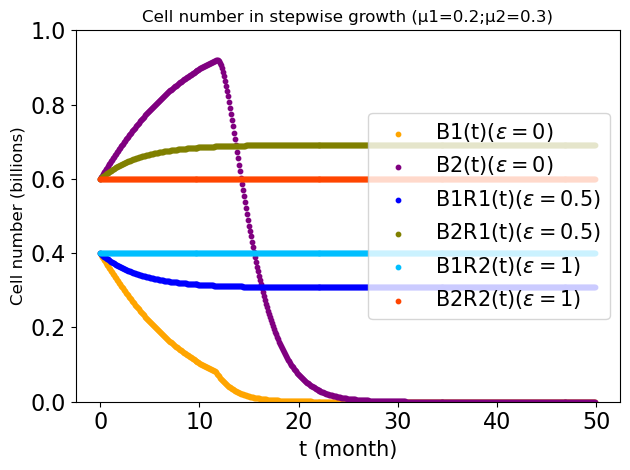

In [26]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
# Store the values of B1 and B2 for each time step in lists.
B1RS1_vals = [0.4]
B2RS1_vals = [0.6]

B1RS2_vals=[0.4]
B2RS2_vals=[0.6]
B1RS3_vals=[0.4]
B2RS3_vals=[0.6]

FluxesS1_list=[0.1538]
FluxesS2_list=[0.3462]
Fluxes1SR1_list=[0.1762]
Fluxes2SR1_list=[0.3238]
Fluxes1SR2_list=[0.2]
Fluxes2SR2_list=[0.3]

### define actual biomass
def B1RS1(t):
    if(t<=0):
        return 0.4
    return B1RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS1_list[-1]
def B2RS1(t):
    if(t<=0):
        return 0.6
    return B2RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS2_list[-1]
def B1RS2(t):
    if(t<=0):
        return 0.4
    return B1RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR1_list[-1]
def B2RS2(t):
    if(t<=0):
        return 0.6
    return B2RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR1_list[-1]
def B1RS3(t):
    if(t<=0):
        return 0.4
    return B1RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR2_list[-1]
def B2RS3(t):
    if(t<=0):
        return 0.6
    return B2RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR2_list[-1]

for t in np.arange(1,500,1):
    B1RS1_t = B1RS1(t)
    B2RS1_t = B2RS1(t)
    B1RS2_t = B1RS2(t)
    B2RS2_t = B2RS2(t)
    B1RS3_t = B1RS3(t)
    B2RS3_t = B2RS3(t)
    
#     B1RS1_vals.append(B1RS1_t)
#     B2RS1_vals.append(B2RS1_t)
#     B1RS2_vals.append(B1RS2_t)
#     B2RS2_vals.append(B2RS2_t)
#     B1RS3_vals.append(B1RS3_t)
#     B2RS3_vals.append(B2RS3_t)
    
    b1RS1=0.5*0.2*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)/(0.2*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.3*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b2RS1=0.5*0.3*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0)/(0.2*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.3*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b1RS2=0.5*0.2*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)/(0.2*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)+0.3*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5))
    b2RS2=0.5*0.3*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5)/(0.2*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)+0.3*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5))
    b1RS3=0.5*0.2*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)/(0.2*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)+0.3*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1))
    b2RS3=0.5*0.3*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1)/(0.2*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)+0.3*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1))
    
    B1RS1_vals.append(B1RS1_t)
    B2RS1_vals.append(B2RS1_t)
    B1RS2_vals.append(B1RS2_t)
    B2RS2_vals.append(B2RS2_t)
    B1RS3_vals.append(B1RS3_t)
    B2RS3_vals.append(B2RS3_t)
    
    model1.reactions.biomass1.upper_bound=b1RS1
    model1.reactions.biomass2.upper_bound=b2RS1
    model1.reactions.DI1X.upper_bound=3*B1RS1_vals[-1]
    model1.reactions.DI2Y.upper_bound=3*B2RS1_vals[-1]
    ### For regulation power=0.5
    model2.reactions.biomass1.upper_bound=b1RS2
    model2.reactions.biomass2.upper_bound=b2RS2
    model2.reactions.DI1X.upper_bound=3*B1RS2_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2RS2_vals[-1]
 ### For regulation power=1
    model3.reactions.biomass1.upper_bound=b1RS3
    model3.reactions.biomass2.upper_bound=b2RS3
    model3.reactions.DI1X.upper_bound=3*B1RS3_vals[-1]
    model3.reactions.DI2Y.upper_bound=3*B2RS3_vals[-1]
        
    sol1 = model1.optimize()
    obj_val = sol1.objective_value
    FluxesS1=sol1.fluxes.loc['biomass1']
    FluxesS2=sol1.fluxes.loc['biomass2']
    sol2 = model2.optimize()
    obj_val = sol2.objective_value
    Fluxes1SR1=sol2.fluxes.loc['biomass1']
    Fluxes2SR1=sol2.fluxes.loc['biomass2']
    sol3 = model3.optimize()
    obj_val = sol3.objective_value
    Fluxes1SR2=sol3.fluxes.loc['biomass1']
    Fluxes2SR2=sol3.fluxes.loc['biomass2']
        
    FluxesS1_list.append(FluxesS1)
    FluxesS2_list.append(FluxesS2)
    Fluxes1SR1_list.append(Fluxes1SR1)
    Fluxes2SR1_list.append(Fluxes2SR1)
    Fluxes1SR2_list.append(Fluxes1SR2)
    Fluxes2SR2_list.append(Fluxes2SR2)
    
    T=t/10
    T_list.append(T)
# print(FluxesS1_list[0],FluxesS2_list[0],Fluxes1SR1_list[0],Fluxes2SR1_list[0],Fluxes1SR2_list[0],Fluxes2SR2_list[0])
plt.scatter(T_list,B1RS1_vals,color='orange',s=10)
plt.scatter(T_list,B2RS1_vals,color='purple',s=10)
plt.scatter(T_list,B1RS2_vals,color='blue',s=10)
plt.scatter(T_list,B2RS2_vals,color='olive',s=10)
plt.scatter(T_list,B1RS3_vals,color='deepskyblue',s=10)
plt.scatter(T_list,B2RS3_vals,color='orangered',s=10)

# plt.scatter(T_list,FluxesS1_list,color='orange',s=10)
# plt.scatter(T_list,FluxesS2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes1SR1_list,color='blue',s=10)
# plt.scatter(T_list,Fluxes2SR1_list,color='olive',s=10)
# plt.scatter(T_list,Fluxes1SR2_list,color='deepskyblue',s=10)
# plt.scatter(T_list,Fluxes2SR2_list,color='orangered',s=10)

plt.xlabel("t (month)",fontsize=15)


plt.ylim(0,1)
plt.title('Cell number in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)''('r'$\varepsilon=0$'')','B2(t)''('r'$\varepsilon=0$'')','B1R1(t)''('r'$\varepsilon=0.5$'')',
            'B2R1(t)''('r'$\varepsilon=0.5$'')','B1R2(t)''('r'$\varepsilon=1$'')','B2R2(t)''('r'$\varepsilon=1$'')'],
           loc='center right')

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)''('r'$\varepsilon=0$'')','b2(t)''('r'$\varepsilon=0$'')','b1R1(t)''('r'$\varepsilon=0.5$'')',
#             'b2R1(t)''('r'$\varepsilon=0.5$'')','b1R2(t)''('r'$\varepsilon=1$'')','b2R2(t)''('r'$\varepsilon=1$'')'],
#            loc='center right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15


plt.tight_layout()
#plt.show()
plt.savefig('Biomass synthesis value for exponential growth with normal regulation',dpi=600)
# plt.savefig('Biomass value for exponential growth with regulation',dpi=300)

##ε=0.1 and 2;  when higher then 0.17, the system could get stable.

<Figure size 640x480 with 0 Axes>

0.1538 0.3462 0.1582 0.3418 0.25 0.25


Text(0.5, 0, 't (months)')

(0.0, 1.0)

Text(0.5, 1.0, 'Cell number in stepwise growth (µ1=0.2;µ2=0.3)')

Text(0, 0.5, 'Cell number')

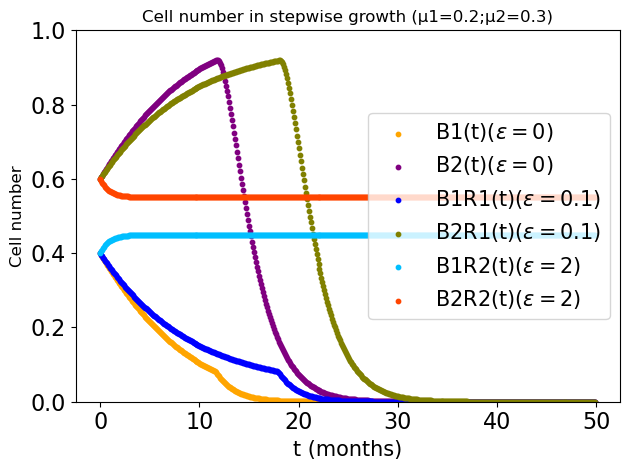

In [84]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
# Store the values of B1 and B2 for each time step in lists.
B1RS1_vals = [0.4]
B2RS1_vals = [0.6]

B1RS2_vals=[0.4]
B2RS2_vals=[0.6]
B1RS3_vals=[0.4]
B2RS3_vals=[0.6]

FluxesS1_list=[0.1538]
FluxesS2_list=[0.3462]
Fluxes1SR1_list=[0.1582]
Fluxes2SR1_list=[0.3418]
Fluxes1SR2_list=[0.25]
Fluxes2SR2_list=[0.25]

### define actual biomass
def B1RS1(t):
    if(t<=0):
        return 0.4
    return B1RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS1_list[-1]
def B2RS1(t):
    if(t<=0):
        return 0.6
    return B2RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS2_list[-1]
def B1RS2(t):
    if(t<=0):
        return 0.4
    return B1RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR1_list[-1]
def B2RS2(t):
    if(t<=0):
        return 0.6
    return B2RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR1_list[-1]
def B1RS3(t):
    if(t<=0):
        return 0.4
    return B1RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR2_list[-1]
def B2RS3(t):
    if(t<=0):
        return 0.6
    return B2RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR2_list[-1]

for t in np.arange(1,500,1):
    B1RS1_t = B1RS1(t)
    B2RS1_t = B2RS1(t)
    B1RS2_t = B1RS2(t)
    B2RS2_t = B2RS2(t)
    B1RS3_t = B1RS3(t)
    B2RS3_t = B2RS3(t)
    
#     B1RS1_vals.append(B1RS1_t)
#     B2RS1_vals.append(B2RS1_t)
#     B1RS2_vals.append(B1RS2_t)
#     B2RS2_vals.append(B2RS2_t)
#     B1RS3_vals.append(B1RS3_t)
#     B2RS3_vals.append(B2RS3_t)
    
    b1RS1=0.5*0.2*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)/(0.2*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.3*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b2RS1=0.5*0.3*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0)/(0.2*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.3*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b1RS2=0.5*0.2*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.1)/(0.2*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.1)+0.3*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.1))
    b2RS2=0.5*0.3*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.1)/(0.2*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.1)+0.3*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.1))
    b1RS3=0.5*0.2*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],2)/(0.2*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],2)+0.3*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],2))
    b2RS3=0.5*0.3*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],2)/(0.2*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],2)+0.3*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],2))
    
    B1RS1_vals.append(B1RS1_t)
    B2RS1_vals.append(B2RS1_t)
    B1RS2_vals.append(B1RS2_t)
    B2RS2_vals.append(B2RS2_t)
    B1RS3_vals.append(B1RS3_t)
    B2RS3_vals.append(B2RS3_t)
    
    model1.reactions.biomass1.upper_bound=b1RS1
    model1.reactions.biomass2.upper_bound=b2RS1
    model1.reactions.DI1X.upper_bound=3*B1RS1_vals[-1]
    model1.reactions.DI2Y.upper_bound=3*B2RS1_vals[-1]
    ### For regulation power=0.1
    model2.reactions.biomass1.upper_bound=b1RS2
    model2.reactions.biomass2.upper_bound=b2RS2
    model2.reactions.DI1X.upper_bound=3*B1RS2_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2RS2_vals[-1]
 ### For regulation power=2
    model3.reactions.biomass1.upper_bound=b1RS3
    model3.reactions.biomass2.upper_bound=b2RS3
    model3.reactions.DI1X.upper_bound=3*B1RS3_vals[-1]
    model3.reactions.DI2Y.upper_bound=3*B2RS3_vals[-1]
        
    sol1 = model1.optimize()
    obj_val = sol1.objective_value
    FluxesS1=sol1.fluxes.loc['biomass1']
    FluxesS2=sol1.fluxes.loc['biomass2']
    sol2 = model2.optimize()
    obj_val = sol2.objective_value
    Fluxes1SR1=sol2.fluxes.loc['biomass1']
    Fluxes2SR1=sol2.fluxes.loc['biomass2']
    sol3 = model3.optimize()
    obj_val = sol3.objective_value
    Fluxes1SR2=sol3.fluxes.loc['biomass1']
    Fluxes2SR2=sol3.fluxes.loc['biomass2']
        
    FluxesS1_list.append(FluxesS1)
    FluxesS2_list.append(FluxesS2)
    Fluxes1SR1_list.append(Fluxes1SR1)
    Fluxes2SR1_list.append(Fluxes2SR1)
    Fluxes1SR2_list.append(Fluxes1SR2)
    Fluxes2SR2_list.append(Fluxes2SR2)
    
    T=t/10
    T_list.append(T)
print(FluxesS1_list[0],FluxesS2_list[0],Fluxes1SR1_list[0],Fluxes2SR1_list[0],Fluxes1SR2_list[0],Fluxes2SR2_list[0])
plt.scatter(T_list,B1RS1_vals,color='orange',s=10)
plt.scatter(T_list,B2RS1_vals,color='purple',s=10)
plt.scatter(T_list,B1RS2_vals,color='blue',s=10)
plt.scatter(T_list,B2RS2_vals,color='olive',s=10)
plt.scatter(T_list,B1RS3_vals,color='deepskyblue',s=10)
plt.scatter(T_list,B2RS3_vals,color='orangered',s=10)

# plt.scatter(T_list,FluxesS1_list,color='orange',s=10)
# plt.scatter(T_list,FluxesS2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes1SR1_list,color='blue',s=10)
# plt.scatter(T_list,Fluxes2SR1_list,color='olive',s=10)
# plt.scatter(T_list,Fluxes1SR2_list,color='deepskyblue',s=10)
# plt.scatter(T_list,Fluxes2SR2_list,color='orangered',s=10)

plt.xlabel("t (month)",fontsize=15)


plt.ylim(0,1)
plt.title('Cell number in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
plt.ylabel("Cell number",fontsize=12)
plt.legend(['B1(t)''('r'$\epsilon=0$'')','B2(t)''('r'$\epsilon=0$'')','B1R1(t)''('r'$\epsilon=0.1$'')',
            'B2R1(t)''('r'$\epsilon=0.1$'')','B1R2(t)''('r'$\epsilon=2$'')','B2R2(t)''('r'$\epsilon=2$'')'],
           loc='center right')

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)''('r'$\epsilon=0$'')','b2(t)''('r'$\epsilon=0$'')','b1R1(t)''('r'$\epsilon=0.1$'')',
#             'b2R1(t)''('r'$\epsilon=0.1$'')','b1R2(t)''('r'$\epsilon=2$'')','b2R2(t)''('r'$\epsilon=2$'')'],
#            loc='center right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15


plt.tight_layout()
# plt.show()
plt.savefig('Biomass synthesis value for exponential growth with normal regulation',dpi=300)
# plt.savefig('Biomass value for exponential growth with regulation',dpi=300)

#### µ1=0.15; µ2=0.35

In [33]:
from cobra.flux_analysis import pfba
# import map visualization tools
from utils import show_map
import escher
map_loc = 'Two cell system model_map.json' # the escher map used below
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


M = cobra.io.load_json_model('Two cell system model.json')
model = M.copy()

In [34]:
### Internal goods X and Y
model.reactions.EX_Com_goodX_e.lower_bound=0
model.reactions.EX_Com_goodY_e.lower_bound=0
model.reactions.EX_glucose_e.lower_bound=-1
model1=model.copy()
model2=model.copy()
model3=model.copy()

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Cell number in stepwise growth (µ1=0.15;µ2=0.35)')

Text(0, 0.5, 'Cell number (billions)')

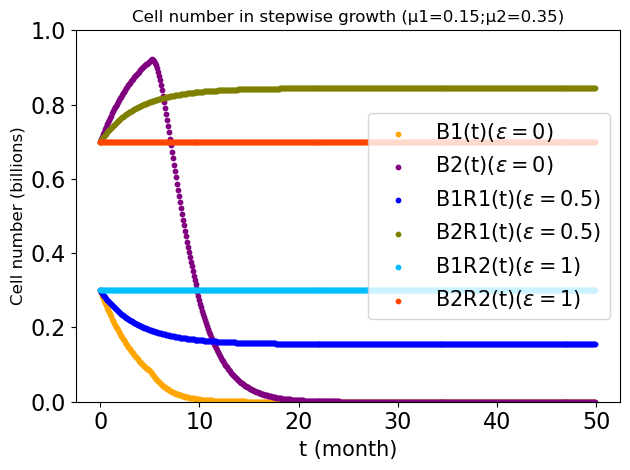

In [35]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
# Store the values of B1 and B2 for each time step in lists.
B1RS1_vals = [0.3]
B2RS1_vals = [0.7]

B1RS2_vals=[0.3]
B2RS2_vals=[0.7]
B1RS3_vals=[0.3]
B2RS3_vals=[0.7]

FluxesS1_list=[0.0776]
FluxesS2_list=[0.4224]
Fluxes1SR1_list=[0.1095]
Fluxes2SR1_list=[0.3905]
Fluxes1SR2_list=[0.15]
Fluxes2SR2_list=[0.35]

### define actual biomass
def B1RS1(t):
    if(t<=0):
        return 0.3
    return B1RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS1_list[-1]
def B2RS1(t):
    if(t<=0):
        return 0.7
    return B2RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS2_list[-1]
def B1RS2(t):
    if(t<=0):
        return 0.3
    return B1RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR1_list[-1]
def B2RS2(t):
    if(t<=0):
        return 0.7
    return B2RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR1_list[-1]
def B1RS3(t):
    if(t<=0):
        return 0.3
    return B1RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR2_list[-1]
def B2RS3(t):
    if(t<=0):
        return 0.7
    return B2RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR2_list[-1]

for t in np.arange(1,500,1):
    B1RS1_t = B1RS1(t)
    B2RS1_t = B2RS1(t)
    B1RS2_t = B1RS2(t)
    B2RS2_t = B2RS2(t)
    B1RS3_t = B1RS3(t)
    B2RS3_t = B2RS3(t)
    
    b1RS1=0.5*0.15*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)/(0.15*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.35*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b2RS1=0.5*0.35*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0)/(0.15*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.35*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b1RS2=0.5*0.15*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)/(0.15*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)+0.35*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5))
    b2RS2=0.5*0.35*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5)/(0.15*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)+0.35*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5))
    b1RS3=0.5*0.15*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)/(0.15*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)+0.35*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1))
    b2RS3=0.5*0.35*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1)/(0.15*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)+0.35*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1))
    B1RS1_vals.append(B1RS1_t)
    B2RS1_vals.append(B2RS1_t)
    B1RS2_vals.append(B1RS2_t)
    B2RS2_vals.append(B2RS2_t)
    B1RS3_vals.append(B1RS3_t)
    B2RS3_vals.append(B2RS3_t)
    model1.reactions.biomass1.upper_bound=b1RS1
    model1.reactions.biomass2.upper_bound=b2RS1
    model1.reactions.DI1X.upper_bound=3*B1RS1_vals[-1]
    model1.reactions.DI2Y.upper_bound=3*B2RS1_vals[-1]
    ### For regulation power=0.5
    model2.reactions.biomass1.upper_bound=b1RS2
    model2.reactions.biomass2.upper_bound=b2RS2
    model2.reactions.DI1X.upper_bound=3*B1RS2_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2RS2_vals[-1]
 ### For regulation power=1
    model3.reactions.biomass1.upper_bound=b1RS3
    model3.reactions.biomass2.upper_bound=b2RS3
    model3.reactions.DI1X.upper_bound=3*B1RS3_vals[-1]
    model3.reactions.DI2Y.upper_bound=3*B2RS3_vals[-1]
        
    sol1 = model1.optimize()
    obj_val = sol1.objective_value
    FluxesS1=sol1.fluxes.loc['biomass1']
    FluxesS2=sol1.fluxes.loc['biomass2']
    sol2 = model2.optimize()
    obj_val = sol2.objective_value
    Fluxes1SR1=sol2.fluxes.loc['biomass1']
    Fluxes2SR1=sol2.fluxes.loc['biomass2']
    sol3 = model3.optimize()
    obj_val = sol3.objective_value
    Fluxes1SR2=sol3.fluxes.loc['biomass1']
    Fluxes2SR2=sol3.fluxes.loc['biomass2']
        
    FluxesS1_list.append(FluxesS1)
    FluxesS2_list.append(FluxesS2)
    Fluxes1SR1_list.append(Fluxes1SR1)
    Fluxes2SR1_list.append(Fluxes2SR1)
    Fluxes1SR2_list.append(Fluxes1SR2)
    Fluxes2SR2_list.append(Fluxes2SR2)
    
    T=t/10
    T_list.append(T)
# print(FluxesS1_list[0],FluxesS2_list[0],Fluxes1SR1_list[0],Fluxes2SR1_list[0],Fluxes1SR2_list[0],Fluxes2SR2_list[0])
plt.scatter(T_list,B1RS1_vals,color='orange',s=10)
plt.scatter(T_list,B2RS1_vals,color='purple',s=10)
plt.scatter(T_list,B1RS2_vals,color='blue',s=10)
plt.scatter(T_list,B2RS2_vals,color='olive',s=10)
plt.scatter(T_list,B1RS3_vals,color='deepskyblue',s=10)
plt.scatter(T_list,B2RS3_vals,color='orangered',s=10)

# plt.scatter(T_list,FluxesS1_list,color='orange',s=10)
# plt.scatter(T_list,FluxesS2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes1SR1_list,color='blue',s=10)
# plt.scatter(T_list,Fluxes2SR1_list,color='olive',s=10)
# plt.scatter(T_list,Fluxes1SR2_list,color='deepskyblue',s=10)
# plt.scatter(T_list,Fluxes2SR2_list,color='orangered',s=10)

plt.xlabel("t (month)",fontsize=15)


plt.ylim(0,1)
plt.title('Cell number in stepwise growth (µ1=0.15;µ2=0.35)',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)''('r'$\epsilon=0$'')','B2(t)''('r'$\epsilon=0$'')','B1R1(t)''('r'$\epsilon=0.5$'')',
            'B2R1(t)''('r'$\epsilon=0.5$'')','B1R2(t)''('r'$\epsilon=1$'')','B2R2(t)''('r'$\epsilon=1$'')'],
           loc='center right')

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in stepwise growth (µ1=0.15;µ2=0.35)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)''('r'$\epsilon=0$'')','b2(t)''('r'$\epsilon=0$'')','b1R1(t)''('r'$\epsilon=0.5$'')',
#             'b2R1(t)''('r'$\epsilon=0.5$'')','b1R2(t)''('r'$\epsilon=1$'')','b2R2(t)''('r'$\epsilon=1$'')'],
#            loc='center right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15


plt.tight_layout()
# plt.show()
plt.savefig('Biomass synthesis value for exponential growth with normal regulation',dpi=600)
# plt.savefig('Biomass value for exponential growth with regulation',dpi=300)

##ε=0.1 and 2;  when higher then 0.36, the system could get stable.

<Figure size 640x480 with 0 Axes>

0.0776 0.4224 0.0833 0.4147 0.25 0.25


Text(0.5, 0, 't (months)')

(0.0, 1.0)

Text(0.5, 1.0, 'Cell number in stepwise growth (µ1=0.15;µ2=0.35)')

Text(0, 0.5, 'Cell number')

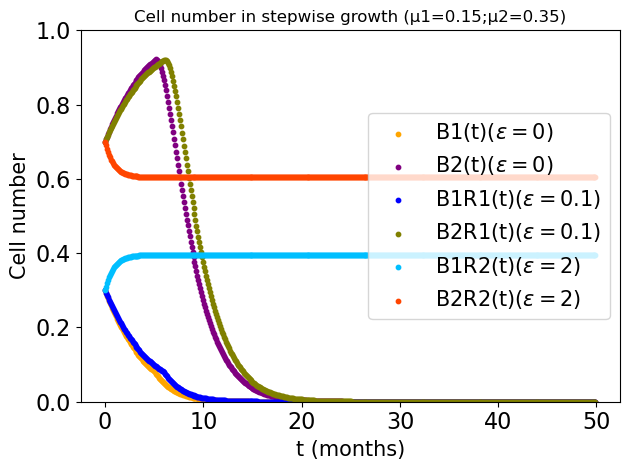

In [90]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
# Store the values of B1 and B2 for each time step in lists.
B1RS1_vals = [0.3]
B2RS1_vals = [0.7]

B1RS2_vals=[0.3]
B2RS2_vals=[0.7]
B1RS3_vals=[0.3]
B2RS3_vals=[0.7]

FluxesS1_list=[0.0776]
FluxesS2_list=[0.4224]
Fluxes1SR1_list=[0.0833]
Fluxes2SR1_list=[0.4147]
Fluxes1SR2_list=[0.25]
Fluxes2SR2_list=[0.25]

### define actual biomass
def B1RS1(t):
    if(t<=0):
        return 0.3
    return B1RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS1_list[-1]
def B2RS1(t):
    if(t<=0):
        return 0.7
    return B2RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS2_list[-1]
def B1RS2(t):
    if(t<=0):
        return 0.3
    return B1RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR1_list[-1]
def B2RS2(t):
    if(t<=0):
        return 0.7
    return B2RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR1_list[-1]
def B1RS3(t):
    if(t<=0):
        return 0.3
    return B1RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR2_list[-1]
def B2RS3(t):
    if(t<=0):
        return 0.7
    return B2RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR2_list[-1]

for t in np.arange(1,500,1):
    B1RS1_t = B1RS1(t)
    B2RS1_t = B2RS1(t)
    B1RS2_t = B1RS2(t)
    B2RS2_t = B2RS2(t)
    B1RS3_t = B1RS3(t)
    B2RS3_t = B2RS3(t)
    
    
    b1RS1=0.5*0.15*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)/(0.15*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.35*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b2RS1=0.5*0.35*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0)/(0.15*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.35*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b1RS2=0.5*0.15*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.1)/(0.15*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.1)+0.35*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.1))
    b2RS2=0.5*0.35*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.1)/(0.15*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.1)+0.35*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.1))
    b1RS3=0.5*0.15*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],2)/(0.15*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],2)+0.35*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],2))
    b2RS3=0.5*0.35*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],2)/(0.15*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],2)+0.35*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],2))
    
    B1RS1_vals.append(B1RS1_t)
    B2RS1_vals.append(B2RS1_t)
    B1RS2_vals.append(B1RS2_t)
    B2RS2_vals.append(B2RS2_t)
    B1RS3_vals.append(B1RS3_t)
    B2RS3_vals.append(B2RS3_t)
    
    model1.reactions.biomass1.upper_bound=b1RS1
    model1.reactions.biomass2.upper_bound=b2RS1
    model1.reactions.DI1X.upper_bound=3*B1RS1_vals[-1]
    model1.reactions.DI2Y.upper_bound=3*B2RS1_vals[-1]
    ### For regulation power=0.1
    model2.reactions.biomass1.upper_bound=b1RS2
    model2.reactions.biomass2.upper_bound=b2RS2
    model2.reactions.DI1X.upper_bound=3*B1RS2_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2RS2_vals[-1]
 ### For regulation power=2
    model3.reactions.biomass1.upper_bound=b1RS3
    model3.reactions.biomass2.upper_bound=b2RS3
    model3.reactions.DI1X.upper_bound=3*B1RS3_vals[-1]
    model3.reactions.DI2Y.upper_bound=3*B2RS3_vals[-1]
        
    sol1 = model1.optimize()
    obj_val = sol1.objective_value
    FluxesS1=sol1.fluxes.loc['biomass1']
    FluxesS2=sol1.fluxes.loc['biomass2']
    sol2 = model2.optimize()
    obj_val = sol2.objective_value
    Fluxes1SR1=sol2.fluxes.loc['biomass1']
    Fluxes2SR1=sol2.fluxes.loc['biomass2']
    sol3 = model3.optimize()
    obj_val = sol3.objective_value
    Fluxes1SR2=sol3.fluxes.loc['biomass1']
    Fluxes2SR2=sol3.fluxes.loc['biomass2']
        
    FluxesS1_list.append(FluxesS1)
    FluxesS2_list.append(FluxesS2)
    Fluxes1SR1_list.append(Fluxes1SR1)
    Fluxes2SR1_list.append(Fluxes2SR1)
    Fluxes1SR2_list.append(Fluxes1SR2)
    Fluxes2SR2_list.append(Fluxes2SR2)
    
    T=t/10
    T_list.append(T)
print(FluxesS1_list[0],FluxesS2_list[0],Fluxes1SR1_list[0],Fluxes2SR1_list[0],Fluxes1SR2_list[0],Fluxes2SR2_list[0])
plt.scatter(T_list,B1RS1_vals,color='orange',s=10)
plt.scatter(T_list,B2RS1_vals,color='purple',s=10)
plt.scatter(T_list,B1RS2_vals,color='blue',s=10)
plt.scatter(T_list,B2RS2_vals,color='olive',s=10)
plt.scatter(T_list,B1RS3_vals,color='deepskyblue',s=10)
plt.scatter(T_list,B2RS3_vals,color='orangered',s=10)

# plt.scatter(T_list,FluxesS1_list,color='orange',s=10)
# plt.scatter(T_list,FluxesS2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes1SR1_list,color='blue',s=10)
# plt.scatter(T_list,Fluxes2SR1_list,color='olive',s=10)
# plt.scatter(T_list,Fluxes1SR2_list,color='deepskyblue',s=10)
# plt.scatter(T_list,Fluxes2SR2_list,color='orangered',s=10)

plt.xlabel("t (month)",fontsize=15)


plt.ylim(0,1)
plt.title('Cell number in stepwise growth (µ1=0.15;µ2=0.35)',fontsize=12)
plt.ylabel("Cell number",fontsize=15)
plt.legend(['B1(t)''('r'$\epsilon=0$'')','B2(t)''('r'$\epsilon=0$'')','B1R1(t)''('r'$\epsilon=0.1$'')',
            'B2R1(t)''('r'$\epsilon=0.1$'')','B1R2(t)''('r'$\epsilon=2$'')','B2R2(t)''('r'$\epsilon=2$'')'],
           loc='center right')

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in stepwise growth (µ1=0.15;µ2=0.35)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)''('r'$\epsilon=0$'')','b2(t)''('r'$\epsilon=0$'')','b1R1(t)''('r'$\epsilon=0.1$'')',
#             'b2R1(t)''('r'$\epsilon=0.1$'')','b1R2(t)''('r'$\epsilon=2$'')','b2R2(t)''('r'$\epsilon=2$'')'],
#            loc='center right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15


plt.tight_layout()
# plt.show()
plt.savefig('Biomass synthesis value for exponential growth with normal regulation',dpi=300)
# plt.savefig('Biomass value for exponential growth with regulation',dpi=300)

#### µ1=0.05; µ2=0.45

In [30]:
from cobra.flux_analysis import pfba
# import map visualization tools
from utils import show_map
import escher
map_loc = 'Two cell system model_map.json' # the escher map used below
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


M = cobra.io.load_json_model('Two cell system model.json')
model = M.copy()

In [31]:
### Internal goods X and Y
model.reactions.EX_Com_goodX_e.lower_bound=0
model.reactions.EX_Com_goodY_e.lower_bound=0
model.reactions.EX_glucose_e.lower_bound=-1
model1=model.copy()
model2=model.copy()
model3=model.copy()

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Cell number in stepwise growth (µ1=0.05;µ2=0.45)')

Text(0, 0.5, 'Cell number (billions)')

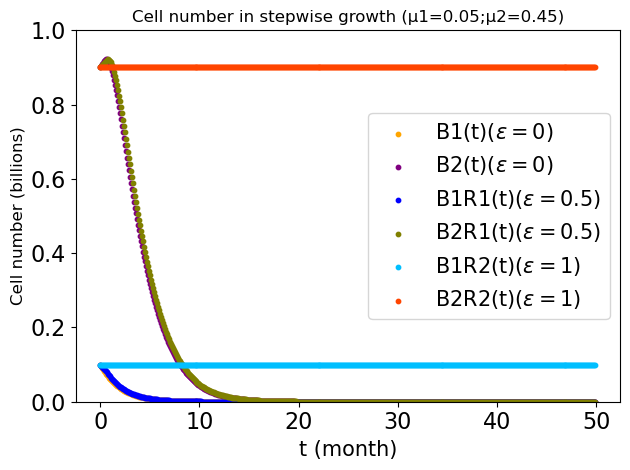

In [32]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
# Store the values of B1 and B2 for each time step in lists.
B1RS1_vals = [0.1]
B2RS1_vals = [0.9]

B1RS2_vals=[0.1]
B2RS2_vals=[0.9]
B1RS3_vals=[0.1]
B2RS3_vals=[0.9]

FluxesS1_list=[0.0061]
FluxesS2_list=[0.4939]
Fluxes1SR1_list=[0.0179]
Fluxes2SR1_list=[0.4821]
Fluxes1SR2_list=[0.05]
Fluxes2SR2_list=[0.45]

### define actual biomass
def B1RS1(t):
    if(t<=0):
        return 0.1
    return B1RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS1_list[-1]
def B2RS1(t):
    if(t<=0):
        return 0.9
    return B2RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS2_list[-1]
def B1RS2(t):
    if(t<=0):
        return 0.1
    return B1RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR1_list[-1]
def B2RS2(t):
    if(t<=0):
        return 0.9
    return B2RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR1_list[-1]
def B1RS3(t):
    if(t<=0):
        return 0.1
    return B1RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR2_list[-1]
def B2RS3(t):
    if(t<=0):
        return 0.9
    return B2RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR2_list[-1]

for t in np.arange(1,500,1):
    B1RS1_t = B1RS1(t)
    B2RS1_t = B2RS1(t)
    B1RS2_t = B1RS2(t)
    B2RS2_t = B2RS2(t)
    B1RS3_t = B1RS3(t)
    B2RS3_t = B2RS3(t)
    
    b1RS1=0.5*0.05*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)/(0.05*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.45*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b2RS1=0.5*0.45*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0)/(0.05*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.45*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b1RS2=0.5*0.05*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)/(0.05*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)+0.45*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5))
    b2RS2=0.5*0.45*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5)/(0.05*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)+0.45*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5))
    b1RS3=0.5*0.05*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)/(0.05*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)+0.45*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1))
    b2RS3=0.5*0.45*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1)/(0.05*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)+0.45*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1))
    B1RS1_vals.append(B1RS1_t)
    B2RS1_vals.append(B2RS1_t)
    B1RS2_vals.append(B1RS2_t)
    B2RS2_vals.append(B2RS2_t)
    B1RS3_vals.append(B1RS3_t)
    B2RS3_vals.append(B2RS3_t)
    
    model1.reactions.biomass1.upper_bound=b1RS1
    model1.reactions.biomass2.upper_bound=b2RS1
    model1.reactions.DI1X.upper_bound=3*B1RS1_vals[-1]
    model1.reactions.DI2Y.upper_bound=3*B2RS1_vals[-1]
    ### For regulation power=0.5
    model2.reactions.biomass1.upper_bound=b1RS2
    model2.reactions.biomass2.upper_bound=b2RS2
    model2.reactions.DI1X.upper_bound=3*B1RS2_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2RS2_vals[-1]
 ### For regulation power=1
    model3.reactions.biomass1.upper_bound=b1RS3
    model3.reactions.biomass2.upper_bound=b2RS3
    model3.reactions.DI1X.upper_bound=3*B1RS3_vals[-1]
    model3.reactions.DI2Y.upper_bound=3*B2RS3_vals[-1]
        
    sol1 = model1.optimize()
    obj_val = sol1.objective_value
    FluxesS1=sol1.fluxes.loc['biomass1']
    FluxesS2=sol1.fluxes.loc['biomass2']
    sol2 = model2.optimize()
    obj_val = sol2.objective_value
    Fluxes1SR1=sol2.fluxes.loc['biomass1']
    Fluxes2SR1=sol2.fluxes.loc['biomass2']
    sol3 = model3.optimize()
    obj_val = sol3.objective_value
    Fluxes1SR2=sol3.fluxes.loc['biomass1']
    Fluxes2SR2=sol3.fluxes.loc['biomass2']
        
    FluxesS1_list.append(FluxesS1)
    FluxesS2_list.append(FluxesS2)
    Fluxes1SR1_list.append(Fluxes1SR1)
    Fluxes2SR1_list.append(Fluxes2SR1)
    Fluxes1SR2_list.append(Fluxes1SR2)
    Fluxes2SR2_list.append(Fluxes2SR2)
    
    T=t/10
    T_list.append(T)
# print(FluxesS1_list[0],FluxesS2_list[0],Fluxes1SR1_list[0],Fluxes2SR1_list[0],Fluxes1SR2_list[0],Fluxes2SR2_list[0])
plt.scatter(T_list,B1RS1_vals,color='orange',s=10)
plt.scatter(T_list,B2RS1_vals,color='purple',s=10)
plt.scatter(T_list,B1RS2_vals,color='blue',s=10)
plt.scatter(T_list,B2RS2_vals,color='olive',s=10)
plt.scatter(T_list,B1RS3_vals,color='deepskyblue',s=10)
plt.scatter(T_list,B2RS3_vals,color='orangered',s=10)

# plt.scatter(T_list,FluxesS1_list,color='orange',s=10)
# plt.scatter(T_list,FluxesS2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes1SR1_list,color='blue',s=10)
# plt.scatter(T_list,Fluxes2SR1_list,color='olive',s=10)
# plt.scatter(T_list,Fluxes1SR2_list,color='deepskyblue',s=10)
# plt.scatter(T_list,Fluxes2SR2_list,color='orangered',s=10)

plt.xlabel("t (month)",fontsize=15)


plt.ylim(0,1)
plt.title('Cell number in stepwise growth (µ1=0.05;µ2=0.45)',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)''('r'$\epsilon=0$'')','B2(t)''('r'$\epsilon=0$'')','B1R1(t)''('r'$\epsilon=0.5$'')',
            'B2R1(t)''('r'$\epsilon=0.5$'')','B1R2(t)''('r'$\epsilon=1$'')','B2R2(t)''('r'$\epsilon=1$'')'],
           loc='center right')

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in stepwise growth (µ1=0.05;µ2=0.45)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)''('r'$\epsilon=0$'')','b2(t)''('r'$\epsilon=0$'')','b1R1(t)''('r'$\epsilon=0.5$'')',
#             'b2R1(t)''('r'$\epsilon=0.5$'')','b1R2(t)''('r'$\epsilon=1$'')','b2R2(t)''('r'$\epsilon=1$'')'],
#            loc='center right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15


plt.tight_layout()
# plt.show()
plt.savefig('Biomass synthesis value for exponential growth with normal regulation',dpi=600)
# plt.savefig('Biomass value for exponential growth with regulation',dpi=300)

##ε=0.1 and 2;  when higher then 0.92, the system could get stable.

<Figure size 640x480 with 0 Axes>

0.0061 0.4939 0.0076 0.4924 0.25 0.25


Text(0.5, 0, 't (months)')

(0.0, 0.5)

Text(0.5, 1.0, 'biomass synthesis rate in stepwise growth (µ1=0.05;µ2=0.45)')

Text(0, 0.5, 'biomass synthesis rate')

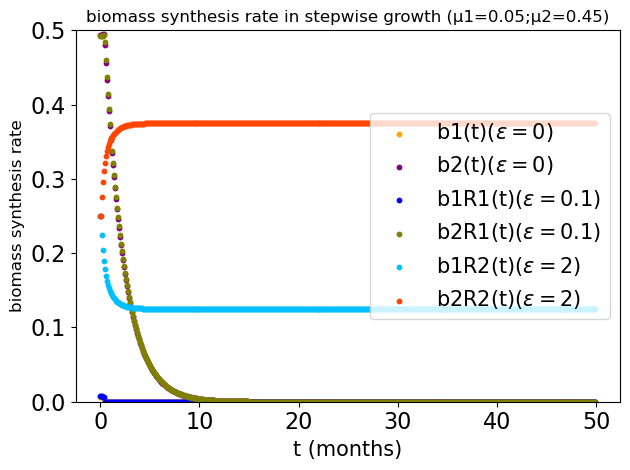

In [74]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
# Store the values of B1 and B2 for each time step in lists.
B1RS1_vals = [0.1]
B2RS1_vals = [0.9]

B1RS2_vals=[0.1]
B2RS2_vals=[0.9]
B1RS3_vals=[0.1]
B2RS3_vals=[0.9]

FluxesS1_list=[0.0061]
FluxesS2_list=[0.4939]
Fluxes1SR1_list=[0.0076]
Fluxes2SR1_list=[0.4924]
Fluxes1SR2_list=[0.25]
Fluxes2SR2_list=[0.25]

### define actual biomass
def B1RS1(t):
    if(t<=0):
        return 0.1
    return B1RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS1_list[-1]
def B2RS1(t):
    if(t<=0):
        return 0.9
    return B2RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS2_list[-1]
def B1RS2(t):
    if(t<=0):
        return 0.1
    return B1RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR1_list[-1]
def B2RS2(t):
    if(t<=0):
        return 0.9
    return B2RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR1_list[-1]
def B1RS3(t):
    if(t<=0):
        return 0.1
    return B1RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR2_list[-1]
def B2RS3(t):
    if(t<=0):
        return 0.9
    return B2RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR2_list[-1]

for t in np.arange(1,500,1):
    B1RS1_t = B1RS1(t)
    B2RS1_t = B2RS1(t)
    B1RS2_t = B1RS2(t)
    B2RS2_t = B2RS2(t)
    B1RS3_t = B1RS3(t)
    B2RS3_t = B2RS3(t)
    
    b1RS1=0.5*0.05*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)/(0.05*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.45*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b2RS1=0.5*0.45*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0)/(0.05*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.45*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b1RS2=0.5*0.05*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.1)/(0.05*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.1)+0.45*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.1))
    b2RS2=0.5*0.45*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.1)/(0.05*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.1)+0.45*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.1))
    b1RS3=0.5*0.05*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],2)/(0.05*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],2)+0.45*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],2))
    b2RS3=0.5*0.45*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],2)/(0.05*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],2)+0.45*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],2))
    
    B1RS1_vals.append(B1RS1_t)
    B2RS1_vals.append(B2RS1_t)
    B1RS2_vals.append(B1RS2_t)
    B2RS2_vals.append(B2RS2_t)
    B1RS3_vals.append(B1RS3_t)
    B2RS3_vals.append(B2RS3_t)
    
    model1.reactions.biomass1.upper_bound=b1RS1
    model1.reactions.biomass2.upper_bound=b2RS1
    model1.reactions.DI1X.upper_bound=3*B1RS1_vals[-1]
    model1.reactions.DI2Y.upper_bound=3*B2RS1_vals[-1]
    ### For regulation power=0.5
    model2.reactions.biomass1.upper_bound=b1RS2
    model2.reactions.biomass2.upper_bound=b2RS2
    model2.reactions.DI1X.upper_bound=3*B1RS2_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2RS2_vals[-1]
 ### For regulation power=1
    model3.reactions.biomass1.upper_bound=b1RS3
    model3.reactions.biomass2.upper_bound=b2RS3
    model3.reactions.DI1X.upper_bound=3*B1RS3_vals[-1]
    model3.reactions.DI2Y.upper_bound=3*B2RS3_vals[-1]
        
    sol1 = model1.optimize()
    obj_val = sol1.objective_value
    FluxesS1=sol1.fluxes.loc['biomass1']
    FluxesS2=sol1.fluxes.loc['biomass2']
    sol2 = model2.optimize()
    obj_val = sol2.objective_value
    Fluxes1SR1=sol2.fluxes.loc['biomass1']
    Fluxes2SR1=sol2.fluxes.loc['biomass2']
    sol3 = model3.optimize()
    obj_val = sol3.objective_value
    Fluxes1SR2=sol3.fluxes.loc['biomass1']
    Fluxes2SR2=sol3.fluxes.loc['biomass2']
        
    FluxesS1_list.append(FluxesS1)
    FluxesS2_list.append(FluxesS2)
    Fluxes1SR1_list.append(Fluxes1SR1)
    Fluxes2SR1_list.append(Fluxes2SR1)
    Fluxes1SR2_list.append(Fluxes1SR2)
    Fluxes2SR2_list.append(Fluxes2SR2)
    
    T=t/10
    T_list.append(T)
print(FluxesS1_list[0],FluxesS2_list[0],Fluxes1SR1_list[0],Fluxes2SR1_list[0],Fluxes1SR2_list[0],Fluxes2SR2_list[0])
# plt.scatter(T_list,B1RS1_vals,color='orange',s=10)
# plt.scatter(T_list,B2RS1_vals,color='purple',s=10)
# plt.scatter(T_list,B1RS2_vals,color='blue',s=10)
# plt.scatter(T_list,B2RS2_vals,color='olive',s=10)
# plt.scatter(T_list,B1RS3_vals,color='deepskyblue',s=10)
# plt.scatter(T_list,B2RS3_vals,color='orangered',s=10)

plt.scatter(T_list,FluxesS1_list,color='orange',s=10)
plt.scatter(T_list,FluxesS2_list,color='purple',s=10)
plt.scatter(T_list,Fluxes1SR1_list,color='blue',s=10)
plt.scatter(T_list,Fluxes2SR1_list,color='olive',s=10)
plt.scatter(T_list,Fluxes1SR2_list,color='deepskyblue',s=10)
plt.scatter(T_list,Fluxes2SR2_list,color='orangered',s=10)

plt.xlabel("t (months)",fontsize=15)


# plt.ylim(0,1)
# plt.title('Cell number in stepwise growth (µ1=0.05;µ2=0.45)',fontsize=12)
# plt.ylabel("Cell number",fontsize=12)
# plt.legend(['B1(t)''('r'$\epsilon=0$'')','B2(t)''('r'$\epsilon=0$'')','B1R1(t)''('r'$\epsilon=0.1$'')',
#             'B2R1(t)''('r'$\epsilon=0.1$'')','B1R2(t)''('r'$\epsilon=2$'')','B2R2(t)''('r'$\epsilon=2$'')'],
#            loc='center right')

plt.ylim(0,0.5)
plt.title('biomass synthesis rate in stepwise growth (µ1=0.05;µ2=0.45)',fontsize=12)
plt.ylabel("biomass synthesis rate",fontsize=12)
plt.legend(['b1(t)''('r'$\epsilon=0$'')','b2(t)''('r'$\epsilon=0$'')','b1R1(t)''('r'$\epsilon=0.1$'')',
            'b2R1(t)''('r'$\epsilon=0.1$'')','b1R2(t)''('r'$\epsilon=2$'')','b2R2(t)''('r'$\epsilon=2$'')'],
           loc='center right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15


plt.tight_layout()
# plt.show()
plt.savefig('Biomass synthesis value for exponential growth with normal regulation',dpi=300)
# plt.savefig('Biomass value for exponential growth with regulation',dpi=300)

#### µ1=0.01; µ2=0.49

In [93]:
from cobra.flux_analysis import pfba
# import map visualization tools
from utils import show_map
import escher
map_loc = 'Two cell system model_map.json' # the escher map used below
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


M = cobra.io.load_json_model('Two cell system model.json')
model = M.copy()

In [94]:
### Internal goods X and Y
model.reactions.EX_Com_goodX_e.lower_bound=0
model.reactions.EX_Com_goodY_e.lower_bound=0
model.reactions.EX_glucose_e.lower_bound=-1
model1=model.copy()
model2=model.copy()
model3=model.copy()

<Figure size 640x480 with 0 Axes>

0.0002 0.1198 0.0015 0.1185 0.01 0.11


Text(0.5, 0, 't (months)')

(0.0, 1.0)

Text(0.5, 1.0, 'Cell number in stepwise growth (µ1=0.01;µ2=0.49)')

Text(0, 0.5, 'Cell number')

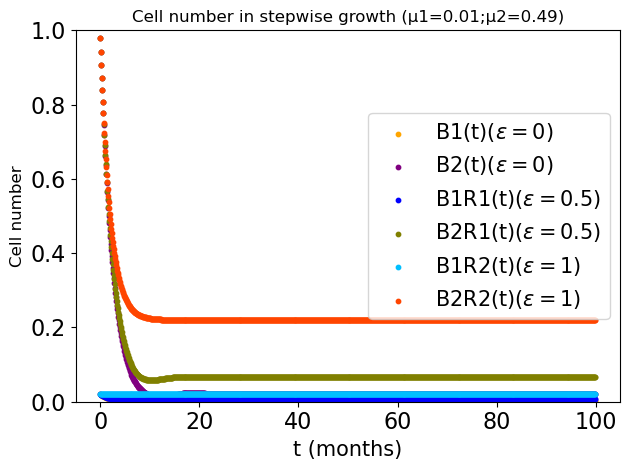

In [95]:
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
# Store the values of B1 and B2 for each time step in lists.
B1RS1_vals = [0.02]
B2RS1_vals = [0.98]

B1RS2_vals=[0.02]
B2RS2_vals=[0.98]
B1RS3_vals=[0.02]
B2RS3_vals=[0.98]

FluxesS1_list=[0.0002]
FluxesS2_list=[0.1198]
Fluxes1SR1_list=[0.0015]
Fluxes2SR1_list=[0.1185]
Fluxes1SR2_list=[0.01]
Fluxes2SR2_list=[0.11]

### define actual biomass
def B1RS1(t):
    if(t<=0):
        return 0.02
    return B1RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS1_list[-1]
def B2RS1(t):
    if(t<=0):
        return 0.98
    return B2RS1_vals[int((t-1)/1)]*0.95+0.1*FluxesS2_list[-1]
def B1RS2(t):
    if(t<=0):
        return 0.02
    return B1RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR1_list[-1]
def B2RS2(t):
    if(t<=0):
        return 0.98
    return B2RS2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR1_list[-1]
def B1RS3(t):
    if(t<=0):
        return 0.02
    return B1RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes1SR2_list[-1]
def B2RS3(t):
    if(t<=0):
        return 0.98
    return B2RS3_vals[int((t-1)/1)]*0.95+0.1*Fluxes2SR2_list[-1]

for t in np.arange(1,1000,1):
    B1RS1_t = B1RS1(t)
    B2RS1_t = B2RS1(t)
    B1RS2_t = B1RS2(t)
    B2RS2_t = B2RS2(t)
    B1RS3_t = B1RS3(t)
    B2RS3_t = B2RS3(t)
    
#     B1RS1_vals.append(B1RS1_t)
#     B2RS1_vals.append(B2RS1_t)
#     B1RS2_vals.append(B1RS2_t)
#     B2RS2_vals.append(B2RS2_t)
#     B1RS3_vals.append(B1RS3_t)
#     B2RS3_vals.append(B2RS3_t)
    
    b1RS1=0.5*0.01*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)/(0.01*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.49*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b2RS1=0.5*0.49*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0)/(0.01*B1RS1_vals[-1]*math.pow(B2RS1_vals[-1],0)+0.49*B2RS1_vals[-1]*math.pow(B1RS1_vals[-1],0))
    b1RS2=0.5*0.01*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)/(0.01*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)+0.49*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5))
    b2RS2=0.5*0.49*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5)/(0.01*B1RS2_vals[-1]*math.pow(B2RS2_vals[-1],0.5)+0.49*B2RS2_vals[-1]*math.pow(B1RS2_vals[-1],0.5))
    b1RS3=0.5*0.01*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)/(0.01*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)+0.49*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1))
    b2RS3=0.5*0.49*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1)/(0.01*B1RS3_vals[-1]*math.pow(B2RS3_vals[-1],1)+0.49*B2RS3_vals[-1]*math.pow(B1RS3_vals[-1],1))
    
    B1RS1_vals.append(B1RS1_t)
    B2RS1_vals.append(B2RS1_t)
    B1RS2_vals.append(B1RS2_t)
    B2RS2_vals.append(B2RS2_t)
    B1RS3_vals.append(B1RS3_t)
    B2RS3_vals.append(B2RS3_t)
    
    model1.reactions.biomass1.upper_bound=b1RS1
    model1.reactions.biomass2.upper_bound=b2RS1
    model1.reactions.DI1X.upper_bound=3*B1RS1_vals[-1]
    model1.reactions.DI2Y.upper_bound=3*B2RS1_vals[-1]
    ### For regulation power=0.5
    model2.reactions.biomass1.upper_bound=b1RS2
    model2.reactions.biomass2.upper_bound=b2RS2
    model2.reactions.DI1X.upper_bound=3*B1RS2_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2RS2_vals[-1]
 ### For regulation power=1
    model3.reactions.biomass1.upper_bound=b1RS3
    model3.reactions.biomass2.upper_bound=b2RS3
    model3.reactions.DI1X.upper_bound=3*B1RS3_vals[-1]
    model3.reactions.DI2Y.upper_bound=3*B2RS3_vals[-1]
        
    sol1 = model1.optimize()
    obj_val = sol1.objective_value
    FluxesS1=sol1.fluxes.loc['biomass1']
    FluxesS2=sol1.fluxes.loc['biomass2']
    sol2 = model2.optimize()
    obj_val = sol2.objective_value
    Fluxes1SR1=sol2.fluxes.loc['biomass1']
    Fluxes2SR1=sol2.fluxes.loc['biomass2']
    sol3 = model3.optimize()
    obj_val = sol3.objective_value
    Fluxes1SR2=sol3.fluxes.loc['biomass1']
    Fluxes2SR2=sol3.fluxes.loc['biomass2']
        
    FluxesS1_list.append(FluxesS1)
    FluxesS2_list.append(FluxesS2)
    Fluxes1SR1_list.append(Fluxes1SR1)
    Fluxes2SR1_list.append(Fluxes2SR1)
    Fluxes1SR2_list.append(Fluxes1SR2)
    Fluxes2SR2_list.append(Fluxes2SR2)
    
    T=t/10
    T_list.append(T)
print(FluxesS1_list[0],FluxesS2_list[0],Fluxes1SR1_list[0],Fluxes2SR1_list[0],Fluxes1SR2_list[0],Fluxes2SR2_list[0])
plt.scatter(T_list,B1RS1_vals,color='orange',s=10)
plt.scatter(T_list,B2RS1_vals,color='purple',s=10)
plt.scatter(T_list,B1RS2_vals,color='blue',s=10)
plt.scatter(T_list,B2RS2_vals,color='olive',s=10)
plt.scatter(T_list,B1RS3_vals,color='deepskyblue',s=10)
plt.scatter(T_list,B2RS3_vals,color='orangered',s=10)

# plt.scatter(T_list,FluxesS1_list,color='orange',s=10)
# plt.scatter(T_list,FluxesS2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes1SR1_list,color='blue',s=10)
# plt.scatter(T_list,Fluxes2SR1_list,color='olive',s=10)
# plt.scatter(T_list,Fluxes1SR2_list,color='deepskyblue',s=10)
# plt.scatter(T_list,Fluxes2SR2_list,color='orangered',s=10)

plt.xlabel("t (months)",fontsize=15)


plt.ylim(0,1)
plt.title('Cell number in stepwise growth (µ1=0.01;µ2=0.49)',fontsize=12)
plt.ylabel("Cell number",fontsize=12)
plt.legend(['B1(t)''('r'$\epsilon=0$'')','B2(t)''('r'$\epsilon=0$'')','B1R1(t)''('r'$\epsilon=0.5$'')',
            'B2R1(t)''('r'$\epsilon=0.5$'')','B1R2(t)''('r'$\epsilon=1$'')','B2R2(t)''('r'$\epsilon=1$'')'],
           loc='center right')

# plt.ylim(0,0.5)
# plt.title('biomass synthesis rate in stepwise growth (µ1=0.01;µ2=0.49)',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)''('r'$\epsilon=0$'')','b2(t)''('r'$\epsilon=0$'')','b1R1(t)''('r'$\epsilon=0.5$'')',
#             'b2R1(t)''('r'$\epsilon=0.5$'')','b1R2(t)''('r'$\epsilon=1$'')','b2R2(t)''('r'$\epsilon=1$'')'],
#            loc='center right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15


plt.tight_layout()
# plt.show()
plt.savefig('Biomass synthesis value for exponential growth with normal regulation',dpi=300)
# plt.savefig('Biomass value for exponential growth with regulation',dpi=300)

In [113]:
print(B1RS1_vals[-1],B2RS1_vals[-1], B1RS2_vals[-1],B2RS2_vals[-1], B1RS3_vals[-1],B2RS3_vals[-1])

0.0018518518611360783 0.020370370308347218 0.0061156612922156125 0.06727227421437151 0.02 0.22000000000000025
